# Proyek Analisis Data: E-Commerce Public Dataset
- **Nama:** Hendri Mardani
- **Email:** hendrimardani290301@gmail.com
- **ID Dicoding:** hendrimardani

## Menentukan Pertanyaan Bisnis

- Produk apa yang paling banyak dan sedikit terjual ?
- Wilayah mana yang paling menguntungkan perusahaan dan paling sering melakukan transaksi ?
- Kapan terakhir pelanggan melakukan transaksi ? (Recency)
- Seberapa sering seorang pelanggan melakukan transaksi  ? (Frequency)
- Berapa banyak uang yang dihabiskan pelanggan dalam beberapa bulan terakhir ? (Monetary)

## Import Semua Packages/Library yang Digunakan

In [2]:
!pip install folium

In [1]:
import pandas as pd
import numpy as np
import folium
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from kagglehub import KaggleDatasetAdapter
from folium import Element
from folium.plugins import MarkerCluster

sns.set()

## Data Wrangling

### Gathering Data

#### Customers

Dataset ini berisi informasi mengenai identitas dan lokasi pelanggan.

Berikut adalah detail penjelasan untuk setiap kolom:

| Nama Atribut | Tipe Data | Deskripsi & Penjelasan |
| :--- | :--- | :--- |
| **`customer_id`** | *String (Hash)* | **ID Kunci per Pesanan.** <br>Ini adalah kunci unik yang dibuat setiap kali pesanan dilakukan. ID ini menghubungkan pelanggan dengan tabel pesanan (*orders dataset*). Jika seorang pelanggan berbelanja dua kali, mereka akan memiliki dua `customer_id` yang berbeda, tetapi `customer_unique_id` yang sama. |
| **`customer_unique_id`** | *String (Hash)* | **ID Unik Pelanggan.** <br>Ini adalah identitas asli dari pelanggan. ID ini tetap sama (persisten) untuk satu orang, tidak peduli berapa kali mereka melakukan pemesanan. Gunakan kolom ini untuk menghitung *retention rate* atau *Customer Lifetime Value*. |
| **`customer_zip_code_prefix`** | *Integer/String* | **Kode Pos (Prefix).** <br>5 digit pertama dari kode pos pelanggan. Digunakan untuk identifikasi wilayah geografis yang lebih spesifik atau untuk pengelompokan logistik. |
| **`customer_city`** | *String* | **Nama Kota.** <br>Nama kota tempat tinggal pelanggan (contoh: *franca*, *sao paulo*, *campinas*). |
| **`customer_state`** | *String* | **Negara Bagian (Provinsi).** <br>Singkatan kode negara bagian di Brasil (contoh: **SP** = São Paulo, **RJ** = Rio de Janeiro, **MG** = Minas Gerais). |

---

In [3]:
customers_df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "hendrimardani/e-commerce-public-dataset",
  path="customers_dataset.csv"
)
customers_df

100%|██████████| 8.62M/8.62M [00:00<00:00, 15.5MB/s]


customer_id                customer_unique_id  \
0      06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1      18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2      4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3      b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4      4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   
...                                 ...                               ...   
99436  17ddf5dd5d51696bb3d7c6291687be6f  1a29b476fee25c95fbafc67c5ac95cf8   
99437  e7b71a9017aa05c9a7fd292d714858e8  d52a67c98be1cf6a5c84435bd38d095d   
99438  5e28dfe12db7fb50a4b2f691faecea5e  e9f50caf99f032f0bf3c55141f019d99   
99439  56b18e2166679b8a959d72dd06da27f9  73c2643a0a458b49f58cea58833b192e   
99440  274fa6071e5e17fe303b9748641082c8  84732c5050c01db9b23e19ba39899398   

       customer_zip_code_prefix          customer_city customer_state  
0                         14409                 franca             SP  
1                          9790  sao bernardo do campo             SP  
2                          1151              sao paulo             SP  
3                          8775        mogi das cruzes             SP  
4                         13056               campinas             SP  
...                         ...                    ...            ...  
99436                      3937              sao paulo             SP  
99437                      6764        taboao da serra             SP  
99438                     60115              fortaleza             CE  
99439                     92120                 canoas             RS  
99440                      6703                  cotia             SP  

[99441 rows x 5 columns]

#### Geolocation

Dataset ini berisi informasi pemetaan kode pos ke koordinat geografis untuk visualisasi lokasi.

Berikut adalah detail penjelasan untuk setiap kolom:

| Nama Atribut | Tipe Data | Deskripsi & Penjelasan |
| :--- | :--- | :--- |
| **`geolocation_zip_code_prefix`** | *Integer* | **Prefix Kode Pos.** <br>5 digit pertama dari kode pos (CEP). Kolom ini adalah kunci utama untuk menghubungkan dataset ini dengan dataset lain (seperti dataset pelanggan atau penjual) guna mendapatkan koordinat lokasi mereka. |
| **`geolocation_lat`** | *Float* | **Latitude (Garis Lintang).** <br>Koordinat yang menentukan posisi utara atau selatan suatu titik. Nilai negatif pada data ini menunjukkan lokasi berada di Belahan Bumi Selatan (*Southern Hemisphere*), sesuai dengan lokasi negara Brasil. |
| **`geolocation_lng`** | *Float* | **Longitude (Garis Bujur).** <br>Koordinat yang menentukan posisi timur atau barat suatu titik. Digunakan bersamaan dengan latitude untuk memplot lokasi presisi pada peta atau menghitung jarak logistik. |
| **`geolocation_city`** | *String* | **Nama Kota.** <br>Nama munisipalitas atau kota yang terkait dengan kode pos tersebut. Satu kode pos bisa saja mencakup beberapa nama area tergantung administrasi kota, namun biasanya merujuk pada satu kota utama. |
| **`geolocation_state`** | *String* | **Negara Bagian (Provinsi).** <br>Singkatan standar dua huruf yang menunjukkan negara bagian di Brasil tempat kota tersebut berada (contoh: **SP** = São Paulo, **RS** = Rio Grande do Sul). |

In [4]:
geolocation_df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "hendrimardani/e-commerce-public-dataset",
  path="geolocation_dataset.csv"
)
geolocation_df

Using Colab cache for faster access to the 'e-commerce-public-dataset' dataset.


geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
0                               1037       -23.545621       -46.639292   
1                               1046       -23.546081       -46.644820   
2                               1046       -23.546129       -46.642951   
3                               1041       -23.544392       -46.639499   
4                               1035       -23.541578       -46.641607   
...                              ...              ...              ...   
1000158                        99950       -28.068639       -52.010705   
1000159                        99900       -27.877125       -52.224882   
1000160                        99950       -28.071855       -52.014716   
1000161                        99980       -28.388932       -51.846871   
1000162                        99950       -28.070104       -52.018658   

        geolocation_city geolocation_state  
0              sao paulo                SP  
1              sao paulo                SP  
2              sao paulo                SP  
3              sao paulo                SP  
4              sao paulo                SP  
...                  ...               ...  
1000158         tapejara                RS  
1000159   getulio vargas                RS  
1000160         tapejara                RS  
1000161  david canabarro                RS  
1000162         tapejara                RS  

[1000163 rows x 5 columns]

#### Order Items

Dataset ini berisi rincian item (barang) yang dibeli dalam setiap transaksi pesanan. Tabel ini menghubungkan pesanan dengan produk dan penjualnya.

Berikut adalah detail penjelasan untuk setiap kolom:

| Nama Atribut | Tipe Data | Deskripsi & Penjelasan |
| :--- | :--- | :--- |
| **`order_id`** | *String (Hash)* | **ID Pesanan.** <br>Kunci unik yang mengidentifikasi pesanan utama. Satu `order_id` bisa muncul beberapa kali di tabel ini jika pelanggan membeli lebih dari satu jenis barang dalam satu kali transaksi (keranjang belanja). |
| **`order_item_id`** | *Integer* | **Nomor Urut Item.** <br>Nomor urut yang mengidentifikasi barang dalam satu pesanan yang sama. Contoh: Jika satu pesanan berisi 3 barang, maka nilainya adalah 1, 2, dan 3. Ini **bukan** jumlah (quantity), melainkan nomor urut baris per pesanan. |
| **`product_id`** | *String (Hash)* | **ID Produk.** <br>Kunci unik untuk mengidentifikasi produk spesifik yang dibeli. Gunakan kolom ini untuk menghubungkan (join) dengan tabel detail produk (*products dataset*). |
| **`seller_id`** | *String (Hash)* | **ID Penjual.** <br>Kunci unik untuk mengidentifikasi penjual yang menjual barang tersebut. Gunakan kolom ini untuk menghubungkan dengan tabel penjual (*sellers dataset*). |
| **`shipping_limit_date`** | *Datetime* | **Batas Waktu Pengiriman.** <br>Tanggal dan waktu batas akhir (deadline) bagi penjual untuk menyerahkan paket barang ke mitra logistik untuk dikirimkan ke pelanggan. |
| **`price`** | *Float* | **Harga Barang.** <br>Harga aktual dari item yang dijual (biaya murni barang, belum termasuk ongkos kirim). |
| **`freight_value`** | *Float* | **Biaya Ongkir.** <br>Biaya pengiriman (freight) untuk item tersebut. Nilai ini dihitung berdasarkan berat/volume barang dan jarak dari penjual ke pembeli. |

In [5]:
order_items_df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "hendrimardani/e-commerce-public-dataset",
  path="order_items_dataset.csv"
)
order_items_df

Using Colab cache for faster access to the 'e-commerce-public-dataset' dataset.


order_id  order_item_id  \
0       00010242fe8c5a6d1ba2dd792cb16214              1   
1       00018f77f2f0320c557190d7a144bdd3              1   
2       000229ec398224ef6ca0657da4fc703e              1   
3       00024acbcdf0a6daa1e931b038114c75              1   
4       00042b26cf59d7ce69dfabb4e55b4fd9              1   
...                                  ...            ...   
112645  fffc94f6ce00a00581880bf54a75a037              1   
112646  fffcd46ef2263f404302a634eb57f7eb              1   
112647  fffce4705a9662cd70adb13d4a31832d              1   
112648  fffe18544ffabc95dfada21779c9644f              1   
112649  fffe41c64501cc87c801fd61db3f6244              1   

                              product_id                         seller_id  \
0       4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1       e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2       c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3       7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4       ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   
...                                  ...                               ...   
112645  4aa6014eceb682077f9dc4bffebc05b0  b8bc237ba3788b23da09c0f1f3a3288c   
112646  32e07fd915822b0765e448c4dd74c828  f3c38ab652836d21de61fb8314b69182   
112647  72a30483855e2eafc67aee5dc2560482  c3cfdc648177fdbbbb35635a37472c53   
112648  9c422a519119dcad7575db5af1ba540e  2b3e4a2a3ea8e01938cabda2a3e5cc79   
112649  350688d9dc1e75ff97be326363655e01  f7ccf836d21b2fb1de37564105216cc1   

        shipping_limit_date   price  freight_value  
0       2017-09-19 09:45:35   58.90          13.29  
1       2017-05-03 11:05:13  239.90          19.93  
2       2018-01-18 14:48:30  199.00          17.87  
3       2018-08-15 10:10:18   12.99          12.79  
4       2017-02-13 13:57:51  199.90          18.14  
...                     ...     ...            ...  
112645  2018-05-02 04:11:01  299.99          43.41  
112646  2018-07-20 04:31:48  350.00          36.53  
112647  2017-10-30 17:14:25   99.90          16.95  
112648  2017-08-21 00:04:32   55.99           8.72  
112649  2018-06-12 17:10:13   43.00          12.79  

[112650 rows x 7 columns]

#### Order Payments

Dataset ini berisi rincian metode dan nominal pembayaran yang digunakan pelanggan untuk membayar pesanan mereka.

Berikut adalah detail penjelasan untuk setiap kolom:

| Nama Atribut | Tipe Data | Deskripsi & Penjelasan |
| :--- | :--- | :--- |
| **`order_id`** | *String (Hash)* | **ID Pesanan.** <br>Kunci unik yang mengidentifikasi pesanan utama. Kolom ini digunakan untuk menghubungkan informasi pembayaran dengan detail pesanan lainnya. |
| **`payment_sequential`** | *Integer* | **Urutan Pembayaran.** <br>Menunjukkan urutan metode pembayaran jika pelanggan menggunakan lebih dari satu metode untuk satu pesanan. <br>Contoh: Pelanggan membayar sebagian dengan *Voucher* (urutan 1) dan sisanya dengan *Kartu Kredit* (urutan 2). |
| **`payment_type`** | *String* | **Tipe Pembayaran.** <br>Metode pembayaran yang dipilih oleh pelanggan. Contoh nilai: *credit_card*, *boleto* (metode tunai/bank transfer populer di Brasil), *voucher*, atau *debit_card*. |
| **`payment_installments`** | *Integer* | **Jumlah Cicilan.** <br>Jumlah angsuran pembayaran yang dipilih pelanggan. <br>Nilai **1** berarti pembayaran penuh (lunas seketika). Nilai **>1** berarti pembayaran dicicil (biasanya untuk kartu kredit). |
| **`payment_value`** | *Float* | **Nilai Transaksi.** <br>Nominal uang yang dibayarkan menggunakan metode tersebut. Jika hanya ada satu metode pembayaran, nilainya sama dengan total belanja. Jika ada beberapa metode (split payment), ini adalah nominal untuk bagian tersebut saja. |

In [6]:
order_payments_df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "hendrimardani/e-commerce-public-dataset",
  path="order_payments_dataset.csv"
)
order_payments_df

Using Colab cache for faster access to the 'e-commerce-public-dataset' dataset.


order_id  payment_sequential payment_type  \
0       b81ef226f3fe1789b1e8b2acac839d17                   1  credit_card   
1       a9810da82917af2d9aefd1278f1dcfa0                   1  credit_card   
2       25e8ea4e93396b6fa0d3dd708e76c1bd                   1  credit_card   
3       ba78997921bbcdc1373bb41e913ab953                   1  credit_card   
4       42fdf880ba16b47b59251dd489d4441a                   1  credit_card   
...                                  ...                 ...          ...   
103881  0406037ad97740d563a178ecc7a2075c                   1       boleto   
103882  7b905861d7c825891d6347454ea7863f                   1  credit_card   
103883  32609bbb3dd69b3c066a6860554a77bf                   1  credit_card   
103884  b8b61059626efa996a60be9bb9320e10                   1  credit_card   
103885  28bbae6599b09d39ca406b747b6632b1                   1       boleto   

        payment_installments  payment_value  
0                          8          99.33  
1                          1          24.39  
2                          1          65.71  
3                          8         107.78  
4                          2         128.45  
...                      ...            ...  
103881                     1         363.31  
103882                     2          96.80  
103883                     1          47.77  
103884                     5         369.54  
103885                     1         191.58  

[103886 rows x 5 columns]

#### Order Reviews

Dataset ini berisi informasi penilaian (rating) dan komentar yang diberikan oleh pelanggan terhadap pengalaman belanja mereka.

Berikut adalah detail penjelasan untuk setiap kolom:

| Nama Atribut | Tipe Data | Deskripsi & Penjelasan |
| :--- | :--- | :--- |
| **`review_id`** | *String (Hash)* | **ID Ulasan.** <br>Kunci unik untuk mengidentifikasi setiap ulasan yang masuk. |
| **`order_id`** | *String (Hash)* | **ID Pesanan.** <br>Kunci unik yang menghubungkan ulasan ini dengan transaksi pesanan aslinya. Satu pesanan biasanya memiliki satu ulasan. |
| **`review_score`** | *Integer* | **Skor Ulasan (Rating).** <br>Nilai kepuasan pelanggan dalam skala 1 sampai 5. <br>**1** = Sangat Buruk, **5** = Sangat Baik. Kolom ini adalah indikator utama untuk mengukur *Customer Satisfaction*. |
| **`review_comment_title`** | *String* | **Judul Komentar.** <br>Judul singkat dari ulasan yang ditulis pelanggan. Kolom ini sering bernilai `NaN` (kosong) karena bersifat opsional saat pelanggan mengisi survei. |
| **`review_comment_message`** | *String* | **Isi Pesan Komentar.** <br>Ulasan teks lengkap dari pelanggan (misalnya: "Barang bagus", "Pengiriman lambat"). Kolom ini sangat berguna untuk analisis teks (*Natural Language Processing*) guna mengetahui sentimen pelanggan. Sering kosong jika pelanggan hanya memberi bintang tanpa menulis kata-kata. |
| **`review_creation_date`** | *Datetime* | **Tanggal Pembuatan Survei.** <br>Tanggal ketika survei kepuasan dikirimkan kepada pelanggan (biasanya terkirim otomatis setelah barang diterima atau estimasi waktu sampai terlewati). |
| **`review_answer_timestamp`** | *Datetime* | **Waktu Jawaban.** <br>Waktu tepatnya (tanggal & jam) ketika pelanggan mengisi dan mengirimkan survei ulasan tersebut kembali ke sistem. |

In [7]:
order_reviews_df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "hendrimardani/e-commerce-public-dataset",
  path="order_reviews_dataset.csv"
)
order_reviews_df

Using Colab cache for faster access to the 'e-commerce-public-dataset' dataset.


review_id                          order_id  \
0      7bc2406110b926393aa56f80a40eba40  73fc7af87114b39712e6da79b0a377eb   
1      80e641a11e56f04c1ad469d5645fdfde  a548910a1c6147796b98fdf73dbeba33   
2      228ce5500dc1d8e020d8d1322874b6f0  f9e4b658b201a9f2ecdecbb34bed034b   
3      e64fb393e7b32834bb789ff8bb30750e  658677c97b385a9be170737859d3511b   
4      f7c4243c7fe1938f181bec41a392bdeb  8e6bfb81e283fa7e4f11123a3fb894f1   
...                                 ...                               ...   
99219  574ed12dd733e5fa530cfd4bbf39d7c9  2a8c23fee101d4d5662fa670396eb8da   
99220  f3897127253a9592a73be9bdfdf4ed7a  22ec9f0669f784db00fa86d035cf8602   
99221  b3de70c89b1510c4cd3d0649fd302472  55d4004744368f5571d1f590031933e4   
99222  1adeb9d84d72fe4e337617733eb85149  7725825d039fc1f0ceb7635e3f7d9206   
99223  efe49f1d6f951dd88b51e6ccd4cc548f  90531360ecb1eec2a1fbb265a0db0508   

       review_score review_comment_title  \
0                 4                  NaN   
1                 5                  NaN   
2                 5                  NaN   
3                 5                  NaN   
4                 5                  NaN   
...             ...                  ...   
99219             5                  NaN   
99220             5                  NaN   
99221             5                  NaN   
99222             4                  NaN   
99223             1                  NaN   

                                  review_comment_message review_creation_date  \
0                                                    NaN  2018-01-18 00:00:00   
1                                                    NaN  2018-03-10 00:00:00   
2                                                    NaN  2018-02-17 00:00:00   
3                  Recebi bem antes do prazo estipulado.  2017-04-21 00:00:00   
4      Parabéns lojas lannister adorei comprar pela I...  2018-03-01 00:00:00   
...                                                  ...                  ...   
99219                                                NaN  2018-07-07 00:00:00   
99220                                                NaN  2017-12-09 00:00:00   
99221  Excelente mochila, entrega super rápida. Super...  2018-03-22 00:00:00   
99222                                                NaN  2018-07-01 00:00:00   
99223  meu produto chegou e ja tenho que devolver, po...  2017-07-03 00:00:00   

      review_answer_timestamp  
0         2018-01-18 21:46:59  
1         2018-03-11 03:05:13  
2         2018-02-18 14:36:24  
3         2017-04-21 22:02:06  
4         2018-03-02 10:26:53  
...                       ...  
99219     2018-07-14 17:18:30  
99220     2017-12-11 20:06:42  
99221     2018-03-23 09:10:43  
99222     2018-07-02 12:59:13  
99223     2017-07-03 21:01:49  

[99224 rows x 7 columns]

#### Orders

Dataset ini adalah tabel utama yang mencatat seluruh perjalanan transaksi, mulai dari pembelian hingga pengiriman.

Berikut adalah detail penjelasan untuk setiap kolom:

| Nama Atribut | Tipe Data | Deskripsi & Penjelasan |
| :--- | :--- | :--- |
| **`order_id`** | *String (Hash)* | **ID Pesanan.** <br>Kunci unik (Primary Key) untuk setiap pesanan. ID ini menghubungkan tabel ini dengan tabel *Order Items* dan *Order Payments*. |
| **`customer_id`** | *String (Hash)* | **ID Pelanggan (Key).** <br>Kunci asing yang menghubungkan pesanan ini ke tabel *Customers Dataset*. <br>**Penting:** Ini berbeda dengan `customer_unique_id`. ID ini spesifik untuk transaksi ini saja. |
| **`order_status`** | *String* | **Status Pesanan.** <br>Status terkini dari pesanan. Nilai meliputi: *delivered* (terkirim), *shipped* (dikirim), *canceled* (dibatalkan), *invoiced*, *processing*, dll. |
| **`order_purchase_timestamp`** | *Datetime* | **Waktu Pembelian.** <br>Tanggal dan jam ketika pelanggan mengklik tombol beli atau menyelesaikan checkout. |
| **`order_approved_at`** | *Datetime* | **Waktu Persetujuan Pembayaran.** <br>Waktu ketika sistem pembayaran mengonfirmasi bahwa transaksi berhasil disetujui. Jarak antara waktu pembelian dan persetujuan bisa digunakan untuk analisis performa *payment gateway*. |
| **`order_delivered_carrier_date`** | *Datetime* | **Waktu Diserahkan ke Logistik.** <br>Waktu ketika penjual menyerahkan paket kepada kurir atau mitra logistik. Selisih waktu ini dengan waktu persetujuan menunjukkan kecepatan pemrosesan penjual (*Seller Processing Time*). |
| **`order_delivered_customer_date`** | *Datetime* | **Waktu Diterima Pelanggan.** <br>Waktu aktual ketika pelanggan menerima barang. Tanggal ini digunakan untuk menghitung total durasi pengiriman (*Actual Delivery Time*). |
| **`order_estimated_delivery_date`** | *Datetime* | **Estimasi Waktu Pengiriman.** <br>Tanggal janji yang ditampilkan kepada pelanggan saat pembelian. Bandingkan tanggal ini dengan tanggal diterima aktual untuk mengukur performa "On-Time Delivery". |

In [8]:
orders_df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "hendrimardani/e-commerce-public-dataset",
  path="orders_dataset.csv"
)
orders_df

Using Colab cache for faster access to the 'e-commerce-public-dataset' dataset.


order_id                       customer_id  \
0      e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1      53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2      47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3      949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4      ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   
...                                 ...                               ...   
99436  9c5dedf39a927c1b2549525ed64a053c  39bd1228ee8140590ac3aca26f2dfe00   
99437  63943bddc261676b46f01ca7ac2f7bd8  1fca14ff2861355f6e5f14306ff977a7   
99438  83c1379a015df1e13d02aae0204711ab  1aa71eb042121263aafbe80c1b562c9c   
99439  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
99440  66dea50a8b16d9b4dee7af250b4be1a5  edb027a75a1449115f6b43211ae02a24   

      order_status order_purchase_timestamp    order_approved_at  \
0        delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1        delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2        delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3        delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4        delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   
...            ...                      ...                  ...   
99436    delivered      2017-03-09 09:54:05  2017-03-09 09:54:05   
99437    delivered      2018-02-06 12:58:58  2018-02-06 13:10:37   
99438    delivered      2017-08-27 14:46:43  2017-08-27 15:04:16   
99439    delivered      2018-01-08 21:28:27  2018-01-08 21:36:21   
99440    delivered      2018-03-08 20:57:30  2018-03-09 11:20:28   

      order_delivered_carrier_date order_delivered_customer_date  \
0              2017-10-04 19:55:00           2017-10-10 21:25:13   
1              2018-07-26 14:31:00           2018-08-07 15:27:45   
2              2018-08-08 13:50:00           2018-08-17 18:06:29   
3              2017-11-22 13:39:59           2017-12-02 00:28:42   
4              2018-02-14 19:46:34           2018-02-16 18:17:02   
...                            ...                           ...   
99436          2017-03-10 11:18:03           2017-03-17 15:08:01   
99437          2018-02-07 23:22:42           2018-02-28 17:37:56   
99438          2017-08-28 20:52:26           2017-09-21 11:24:17   
99439          2018-01-12 15:35:03           2018-01-25 23:32:54   
99440          2018-03-09 22:11:59           2018-03-16 13:08:30   

      order_estimated_delivery_date  
0               2017-10-18 00:00:00  
1               2018-08-13 00:00:00  
2               2018-09-04 00:00:00  
3               2017-12-15 00:00:00  
4               2018-02-26 00:00:00  
...                             ...  
99436           2017-03-28 00:00:00  
99437           2018-03-02 00:00:00  
99438           2017-09-27 00:00:00  
99439           2018-02-15 00:00:00  
99440           2018-04-03 00:00:00  

[99441 rows x 8 columns]

#### Product Category Name Translation

Dataset ini berfungsi sebagai kamus penerjemah. Karena dataset asli berasal dari e-commerce Brasil, nama kategori di tabel produk menggunakan Bahasa Portugis. Tabel ini memetakan nama tersebut ke Bahasa Inggris agar lebih mudah dianalisis secara global.

Berikut adalah detail penjelasan untuk setiap kolom:

| Nama Atribut | Tipe Data | Deskripsi & Penjelasan |
| :--- | :--- | :--- |
| **`product_category_name`** | *String* | **Nama Kategori (Portugis).** <br>Nama kategori produk dalam bahasa aslinya (Portugis). Kolom ini adalah kunci untuk menghubungkan (*join*) tabel ini dengan tabel **Products Dataset**. Contoh: *beleza_saude*, *cama_mesa_banho*. |
| **`product_category_name_english`** | *String* | **Nama Kategori (Inggris).** <br>Terjemahan nama kategori dalam Bahasa Inggris. Kolom ini sangat berguna untuk visualisasi data agar audiens internasional dapat memahami konteks kategori produk. Contoh: *health_beauty*, *bed_bath_table*. |

In [9]:
product_category_name_translation_df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "hendrimardani/e-commerce-public-dataset",
  path="product_category_name_translation.csv"
)
product_category_name_translation_df

Using Colab cache for faster access to the 'e-commerce-public-dataset' dataset.


product_category_name product_category_name_english
0                    beleza_saude                 health_beauty
1          informatica_acessorios         computers_accessories
2                      automotivo                          auto
3                 cama_mesa_banho                bed_bath_table
4                moveis_decoracao               furniture_decor
..                            ...                           ...
66                         flores                       flowers
67             artes_e_artesanato         arts_and_craftmanship
68                fraldas_higiene           diapers_and_hygiene
69  fashion_roupa_infanto_juvenil     fashion_childrens_clothes
70             seguros_e_servicos         security_and_services

[71 rows x 2 columns]

#### Products

Dataset ini berisi informasi detail mengenai karakteristik produk yang dijual di marketplace, termasuk kategori dan dimensi fisiknya.

Berikut adalah detail penjelasan untuk setiap kolom:

| Nama Atribut | Tipe Data | Deskripsi & Penjelasan |
| :--- | :--- | :--- |
| **`product_id`** | *String (Hash)* | **ID Produk.** <br>Kunci unik untuk mengidentifikasi produk. Kolom ini digunakan untuk menghubungkan informasi produk dengan tabel *Order Items*. |
| **`product_category_name`** | *String* | **Kategori Produk.** <br>Nama kategori produk dalam Bahasa Portugis (contoh: *beleza_saude*, *informatica_acessorios*). Kolom ini bisa diterjemahkan ke bahasa Inggris menggunakan dataset *Category Translation*. |
| **`product_name_lenght`** | *Float* | **Panjang Nama Produk.** <br>Jumlah karakter yang terdapat pada judul/nama produk. Informasi ini berguna untuk analisis kualitas *listing* (apakah judul terlalu pendek atau deskriptif). |
| **`product_description_lenght`** | *Float* | **Panjang Deskripsi.** <br>Jumlah karakter dalam teks deskripsi produk. Deskripsi yang lebih panjang biasanya memberikan informasi yang lebih detail kepada pembeli. |
| **`product_photos_qty`** | *Float* | **Jumlah Foto.** <br>Jumlah foto yang ditampilkan pada halaman produk tersebut. Jumlah foto sering kali berkorelasi dengan kepercayaan pembeli dan tingkat konversi penjualan. |
| **`product_weight_g`** | *Float* | **Berat Produk (Gram).** <br>Berat fisik produk dalam satuan gram. Nilai ini sangat penting untuk menghitung biaya pengiriman (*freight value*). |
| **`product_length_cm`** | *Float* | **Panjang Produk (cm).** <br>Dimensi panjang kemasan produk dalam sentimeter. |
| **`product_height_cm`** | *Float* | **Tinggi Produk (cm).** <br>Dimensi tinggi kemasan produk dalam sentimeter. |
| **`product_width_cm`** | *Float* | **Lebar Produk (cm).** <br>Dimensi lebar kemasan produk dalam sentimeter. Ketiga dimensi ini (P x L x T) digunakan logistik untuk menghitung berat volumetrik paket. |

In [10]:
products_df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "hendrimardani/e-commerce-public-dataset",
  path="products_dataset.csv"
)
products_df

Using Colab cache for faster access to the 'e-commerce-public-dataset' dataset.


product_id              product_category_name  \
0      1e9e8ef04dbcff4541ed26657ea517e5                         perfumaria   
1      3aa071139cb16b67ca9e5dea641aaa2f                              artes   
2      96bd76ec8810374ed1b65e291975717f                      esporte_lazer   
3      cef67bcfe19066a932b7673e239eb23d                              bebes   
4      9dc1a7de274444849c219cff195d0b71              utilidades_domesticas   
...                                 ...                                ...   
32946  a0b7d5a992ccda646f2d34e418fff5a0                   moveis_decoracao   
32947  bf4538d88321d0fd4412a93c974510e6  construcao_ferramentas_iluminacao   
32948  9a7c6041fa9592d9d9ef6cfe62a71f8c                    cama_mesa_banho   
32949  83808703fc0706a22e264b9d75f04a2e             informatica_acessorios   
32950  106392145fca363410d287a815be6de4                    cama_mesa_banho   

       product_name_lenght  product_description_lenght  product_photos_qty  \
0                     40.0                       287.0                 1.0   
1                     44.0                       276.0                 1.0   
2                     46.0                       250.0                 1.0   
3                     27.0                       261.0                 1.0   
4                     37.0                       402.0                 4.0   
...                    ...                         ...                 ...   
32946                 45.0                        67.0                 2.0   
32947                 41.0                       971.0                 1.0   
32948                 50.0                       799.0                 1.0   
32949                 60.0                       156.0                 2.0   
32950                 58.0                       309.0                 1.0   

       product_weight_g  product_length_cm  product_height_cm  \
0                 225.0               16.0               10.0   
1                1000.0               30.0               18.0   
2                 154.0               18.0                9.0   
3                 371.0               26.0                4.0   
4                 625.0               20.0               17.0   
...                 ...                ...                ...   
32946           12300.0               40.0               40.0   
32947            1700.0               16.0               19.0   
32948            1400.0               27.0                7.0   
32949             700.0               31.0               13.0   
32950            2083.0               12.0                2.0   

       product_width_cm  
0                  14.0  
1                  20.0  
2                  15.0  
3                  26.0  
4                  13.0  
...                 ...  
32946              40.0  
32947              16.0  
32948              27.0  
32949              20.0  
32950               7.0  

[32951 rows x 9 columns]

#### Sellers

Dataset ini berisi informasi mengenai identitas dan lokasi penjual (*merchant*). Data ini digunakan untuk melacak asal barang dan menghitung jarak logistik.

Berikut adalah detail penjelasan untuk setiap kolom:

| Nama Atribut | Tipe Data | Deskripsi & Penjelasan |
| :--- | :--- | :--- |
| **`seller_id`** | *String (Hash)* | **ID Penjual.** <br>Kunci unik yang mengidentifikasi setiap penjual di platform. ID ini digunakan untuk menghubungkan penjual dengan produk yang terjual di tabel *Order Items*. |
| **`seller_zip_code_prefix`** | *Integer* | **Kode Pos (Prefix).** <br>5 digit pertama dari kode pos lokasi gudang atau toko penjual. Informasi ini krusial untuk menghitung biaya ongkir (*freight value*) dan estimasi waktu pengiriman ke pelanggan. |
| **`seller_city`** | *String* | **Kota Penjual.** <br>Nama kota tempat penjual beroperasi (contoh: *campinas*, *rio de janeiro*). |
| **`seller_state`** | *String* | **Negara Bagian (Provinsi).** <br>Singkatan kode negara bagian lokasi penjual (contoh: **SP** = São Paulo, **SC** = Santa Catarina). Data ini berguna untuk menganalisis distribusi penjual di seluruh negeri. |

In [11]:
sellers_df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "hendrimardani/e-commerce-public-dataset",
  path="sellers_dataset.csv"
)
sellers_df

Using Colab cache for faster access to the 'e-commerce-public-dataset' dataset.


seller_id  seller_zip_code_prefix  \
0     3442f8959a84dea7ee197c632cb2df15                   13023   
1     d1b65fc7debc3361ea86b5f14c68d2e2                   13844   
2     ce3ad9de960102d0677a81f5d0bb7b2d                   20031   
3     c0f3eea2e14555b6faeea3dd58c1b1c3                    4195   
4     51a04a8a6bdcb23deccc82b0b80742cf                   12914   
...                                ...                     ...   
3090  98dddbc4601dd4443ca174359b237166                   87111   
3091  f8201cab383e484733266d1906e2fdfa                   88137   
3092  74871d19219c7d518d0090283e03c137                    4650   
3093  e603cf3fec55f8697c9059638d6c8eb5                   96080   
3094  9e25199f6ef7e7c347120ff175652c3b                   12051   

            seller_city seller_state  
0              campinas           SP  
1            mogi guacu           SP  
2        rio de janeiro           RJ  
3             sao paulo           SP  
4     braganca paulista           SP  
...                 ...          ...  
3090            sarandi           PR  
3091            palhoca           SC  
3092          sao paulo           SP  
3093            pelotas           RS  
3094            taubate           SP  

[3095 rows x 4 columns]

### Assessing Data

#### Customers

In [12]:
customers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


**Insight:**
- Tidak terdapat nilai kosong dalam dataset ini.
- Tipe data sudah sesuai

In [13]:
customers_df.describe()

customer_zip_code_prefix
count              99441.000000
mean               35137.474583
std                29797.938996
min                 1003.000000
25%                11347.000000
50%                24416.000000
75%                58900.000000
max                99990.000000

#### Geolocation

In [14]:
geolocation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


#### Order Items

In [15]:
order_items_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


**Insight:**
- Tipe data pada kolom shipping_limit_date masih belum sesuai seharusnya berbentuk tipe data datetime

In [16]:
order_items_df.describe()

order_item_id          price  freight_value
count  112650.000000  112650.000000  112650.000000
mean        1.197834     120.653739      19.990320
std         0.705124     183.633928      15.806405
min         1.000000       0.850000       0.000000
25%         1.000000      39.900000      13.080000
50%         1.000000      74.990000      16.260000
75%         1.000000     134.900000      21.150000
max        21.000000    6735.000000     409.680000

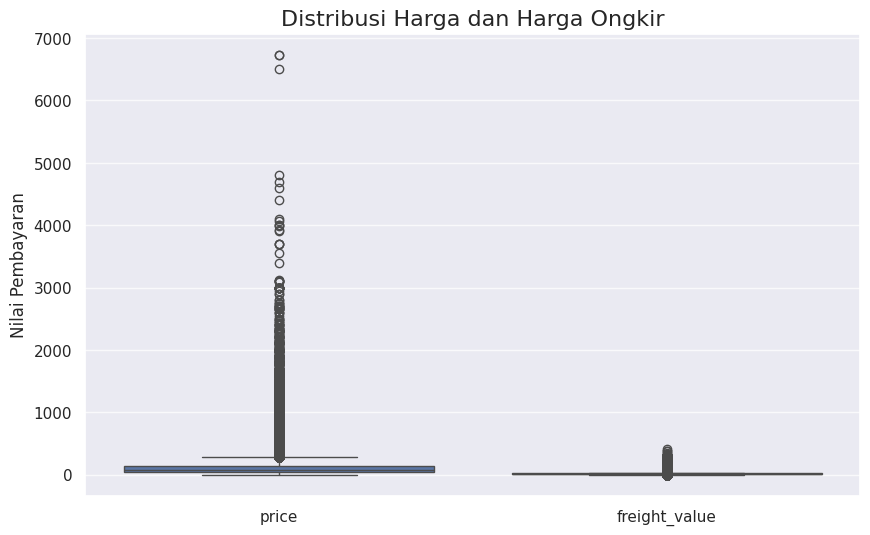

In [17]:
plt.figure(figsize=(10, 6))
sns.boxplot(order_items_df[['price', 'freight_value']])
plt.title('Distribusi Harga dan Harga Ongkir', fontsize=16)
plt.ylabel('Nilai Pembayaran', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.show()

**Insight:**
- Atribut price dan freight_value memiliki outlier yang banyak. Namun, disini tidak akan hapus dan akan membiarkan outlier itu. karena nilai maksimal dari atribut price 6735 dan atribut freight_value 409.68 masih tergolong wajar dan bisa dipastikan bukan kesalahan *human error*. Jika kita mengganti atau justru menghapus akan menghilangkan banyak informasi harta karun dari data itu sendiri.

#### Order Payments

In [18]:
order_payments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [19]:
order_payments_df.describe()

payment_sequential  payment_installments  payment_value
count       103886.000000         103886.000000  103886.000000
mean             1.092679              2.853349     154.100380
std              0.706584              2.687051     217.494064
min              1.000000              0.000000       0.000000
25%              1.000000              1.000000      56.790000
50%              1.000000              1.000000     100.000000
75%              1.000000              4.000000     171.837500
max             29.000000             24.000000   13664.080000

In [20]:
order_payments_df[order_payments_df["payment_installments"] == 0]

order_id  payment_sequential payment_type  \
46982  744bade1fcf9ff3f31d860ace076d422                   2  credit_card   
79014  1a57108394169c0b47d8f876acc9ba2d                   2  credit_card   

       payment_installments  payment_value  
46982                     0          58.69  
79014                     0         129.94

In [21]:
order_payments_df[(order_payments_df["payment_sequential"] == 2) & (order_payments_df["payment_type"] == "credit_card")]

order_id  payment_sequential payment_type  \
199     332c6742772f2df936696b6512b10edb                   2  credit_card   
949     98f0e2b0d85754ca3b4e06d70f0f63a2                   2  credit_card   
1102    5373c26702420c0f842871e489365e20                   2  credit_card   
1135    eca3005a4f60ceb77b67a30b74095ddf                   2  credit_card   
1294    b18478bbf9b2283e3d12452f69fd9ce2                   2  credit_card   
...                                  ...                 ...          ...   
102295  c75e9a685439f75e990bcf13443f02c5                   2  credit_card   
102341  407cc9b2c7575dbff71cb23b6cc26814                   2  credit_card   
102674  ef13a698cf88c9e17ccca0261e0b9e7a                   2  credit_card   
102724  55adc5cef9556477770f0b858669f8fc                   2  credit_card   
103455  4c48c455b847c7a5d291a519e1e42d28                   2  credit_card   

        payment_installments  payment_value  
199                        6         134.55  
949                        2          70.00  
1102                       1          12.59  
1135                       1           3.99  
1294                       1          79.92  
...                      ...            ...  
102295                     4         497.54  
102341                     7          76.39  
102674                     8          94.49  
102724                     2          65.55  
103455                     2          26.48  

[318 rows x 5 columns]

**Insight:**
- Jika dilihat dari atribut payment_installments terdapat data anomali dengan nilai 0 seperti yang kita tahu dalam melakukan pembayaran khususnya tipe pembayaran kartu kredit setidaknya ada 1 kali proses pembayan. Maka dari itu nilai 0 ini akan kita lakukan imputation (perubahan nilai dari 0 menjadi 1 (median dari atribut payment_installments)

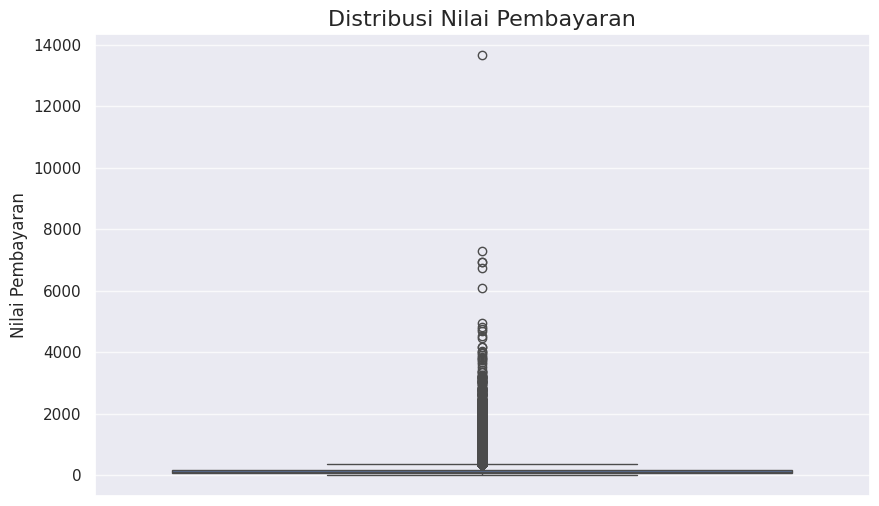

In [22]:
plt.figure(figsize=(10, 6))
sns.boxplot(y=order_payments_df['payment_value'])
plt.title('Distribusi Nilai Pembayaran', fontsize=16)
plt.ylabel('Nilai Pembayaran', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.show()

**Insight:**
- Terdapat outlier banyak sekali pada atribut **payment_value**. Namun, outlier ini tidak dihapus karena bisa saja pelanggan tersebut ada yang sangat sultan dan bukan diakibatkan kesalahan manusia *(human error)*, informasi ini tentunya sangat berharga untuk dianalisis lebih lanjut dibandingkan dibuang atau diganti dengan nailai lain yang justru akan menghilangkan harta karun informasi faktanya

#### Order Reviews

In [23]:
order_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


**Insight:**
- Terdapat nilai kosong pada atribut review_comment_title dan review_comment_message. Nilai kosong ini bisa dibiarkan saja karena nilai kosong tersebut merujuk pada sebuah komentar bukan pada data statistik atau data kuantitatif yang akan kita capai.

In [24]:
order_reviews_df.describe()

review_score
count  99224.000000
mean       4.086421
std        1.347579
min        1.000000
25%        4.000000
50%        5.000000
75%        5.000000
max        5.000000

#### Orders

In [25]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


**Insight:**
- Masih terdapat tipe data yang tidak sesuai pada kolom order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date seharusnya tipe data datetime. Tapi kali ini akan dilakukan konversi hanya pada atribut order_purchase_timestamp karena atribut tersebut digunakan pada proses RFM analisis
- Terdapat nilai kosong pada atribut **order_approved_at** sebanyak 160 data
- Terdapat nilai kosong pada atribut **order_delivered_carrier_date** sebanyak 1783 data
- Terdapat nilai kosong pada atribut **order_delivered_customer_date** sebanyak 2965  data
- Nilai kosong ini bisa dibiarkan saja, karena jika kita menghapusnya **kita akan kehilangan informasi dari dataset ini**. Selain itu alasan tidak dihapusnya nilai kosong ini hanya terdapat pada atribut terkait tanggal pengiriman saja bukan terkait data kuantitatif ataupun data kualitatif (selain datetime)

#### Product Category Name Translation

In [26]:
product_category_name_translation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          71 non-null     object
 1   product_category_name_english  71 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB


#### Products

In [27]:
products_df.head()

product_id  product_category_name  \
0  1e9e8ef04dbcff4541ed26657ea517e5             perfumaria   
1  3aa071139cb16b67ca9e5dea641aaa2f                  artes   
2  96bd76ec8810374ed1b65e291975717f          esporte_lazer   
3  cef67bcfe19066a932b7673e239eb23d                  bebes   
4  9dc1a7de274444849c219cff195d0b71  utilidades_domesticas   

   product_name_lenght  product_description_lenght  product_photos_qty  \
0                 40.0                       287.0                 1.0   
1                 44.0                       276.0                 1.0   
2                 46.0                       250.0                 1.0   
3                 27.0                       261.0                 1.0   
4                 37.0                       402.0                 4.0   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  
0             225.0               16.0               10.0              14.0  
1            1000.0               30.0               18.0              20.0  
2             154.0               18.0                9.0              15.0  
3             371.0               26.0                4.0              26.0  
4             625.0               20.0               17.0              13.0

In [28]:
products_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [29]:
products_df.describe()

product_name_lenght  product_description_lenght  product_photos_qty  \
count         32341.000000                32341.000000        32341.000000   
mean             48.476949                  771.495285            2.188986   
std              10.245741                  635.115225            1.736766   
min               5.000000                    4.000000            1.000000   
25%              42.000000                  339.000000            1.000000   
50%              51.000000                  595.000000            1.000000   
75%              57.000000                  972.000000            3.000000   
max              76.000000                 3992.000000           20.000000   

       product_weight_g  product_length_cm  product_height_cm  \
count      32949.000000       32949.000000       32949.000000   
mean        2276.472488          30.815078          16.937661   
std         4282.038731          16.914458          13.637554   
min            0.000000           7.000000           2.000000   
25%          300.000000          18.000000           8.000000   
50%          700.000000          25.000000          13.000000   
75%         1900.000000          38.000000          21.000000   
max        40425.000000         105.000000         105.000000   

       product_width_cm  
count      32949.000000  
mean          23.196728  
std           12.079047  
min            6.000000  
25%           15.000000  
50%           20.000000  
75%           30.000000  
max          118.000000

In [30]:
products_df[products_df["product_category_name"].isnull()]

product_id product_category_name  \
105    a41e356c76fab66334f36de622ecbd3a                   NaN   
128    d8dee61c2034d6d075997acef1870e9b                   NaN   
145    56139431d72cd51f19eb9f7dae4d1617                   NaN   
154    46b48281eb6d663ced748f324108c733                   NaN   
197    5fb61f482620cb672f5e586bb132eae9                   NaN   
...                                 ...                   ...   
32515  b0a0c5dd78e644373b199380612c350a                   NaN   
32589  10dbe0fbaa2c505123c17fdc34a63c56                   NaN   
32616  bd2ada37b58ae94cc838b9c0569fecd8                   NaN   
32772  fa51e914046aab32764c41356b9d4ea4                   NaN   
32852  c4ceee876c82b8328e9c293fa0e1989b                   NaN   

       product_name_lenght  product_description_lenght  product_photos_qty  \
105                    NaN                         NaN                 NaN   
128                    NaN                         NaN                 NaN   
145                    NaN                         NaN                 NaN   
154                    NaN                         NaN                 NaN   
197                    NaN                         NaN                 NaN   
...                    ...                         ...                 ...   
32515                  NaN                         NaN                 NaN   
32589                  NaN                         NaN                 NaN   
32616                  NaN                         NaN                 NaN   
32772                  NaN                         NaN                 NaN   
32852                  NaN                         NaN                 NaN   

       product_weight_g  product_length_cm  product_height_cm  \
105               650.0               17.0               14.0   
128               300.0               16.0                7.0   
145               200.0               20.0               20.0   
154             18500.0               41.0               30.0   
197               300.0               35.0                7.0   
...                 ...                ...                ...   
32515            1800.0               30.0               20.0   
32589             800.0               30.0               10.0   
32616             200.0               21.0                8.0   
32772            1300.0               45.0               16.0   
32852             700.0               28.0                3.0   

       product_width_cm  
105                12.0  
128                20.0  
145                20.0  
154                41.0  
197                12.0  
...                 ...  
32515              70.0  
32589              23.0  
32616              16.0  
32772              45.0  
32852              43.0  

[610 rows x 9 columns]

**Insight:**
- Terdapat nilai kosong pada atribut **product_category_name, product_name_length, product_description_length, dan product_photos_qty**. Jika dilihat atribut-atribut ini adalah identitas dari produk. Maka dari itu nilai-nilai yang kosong ini bisa isi dengan nilai mode (nilai modus) yaitu nilai yang paling sering muncul pada data kualitatif atribut **product_category_name**

In [31]:
products_df[products_df["product_weight_g"].isnull()]

product_id product_category_name  \
8578   09ff539a621711667c43eba6a3bd8466                 bebes   
18851  5eb564652db742ff8f28759cd8d2652a                   NaN   

       product_name_lenght  product_description_lenght  product_photos_qty  \
8578                  60.0                       865.0                 3.0   
18851                  NaN                         NaN                 NaN   

       product_weight_g  product_length_cm  product_height_cm  \
8578                NaN                NaN                NaN   
18851               NaN                NaN                NaN   

       product_width_cm  
8578                NaN  
18851               NaN

**Insight:**
- Untuk semua atribut yang nilainya kosong semua **bisa dihapus** karena kita tidak memiliki cukup banyak informasi didalamnya. Selain itu, 3 atribut masih bisa dipertahankan dengan mengisi nilai rata-rata.

In [32]:
products_df

product_id              product_category_name  \
0      1e9e8ef04dbcff4541ed26657ea517e5                         perfumaria   
1      3aa071139cb16b67ca9e5dea641aaa2f                              artes   
2      96bd76ec8810374ed1b65e291975717f                      esporte_lazer   
3      cef67bcfe19066a932b7673e239eb23d                              bebes   
4      9dc1a7de274444849c219cff195d0b71              utilidades_domesticas   
...                                 ...                                ...   
32946  a0b7d5a992ccda646f2d34e418fff5a0                   moveis_decoracao   
32947  bf4538d88321d0fd4412a93c974510e6  construcao_ferramentas_iluminacao   
32948  9a7c6041fa9592d9d9ef6cfe62a71f8c                    cama_mesa_banho   
32949  83808703fc0706a22e264b9d75f04a2e             informatica_acessorios   
32950  106392145fca363410d287a815be6de4                    cama_mesa_banho   

       product_name_lenght  product_description_lenght  product_photos_qty  \
0                     40.0                       287.0                 1.0   
1                     44.0                       276.0                 1.0   
2                     46.0                       250.0                 1.0   
3                     27.0                       261.0                 1.0   
4                     37.0                       402.0                 4.0   
...                    ...                         ...                 ...   
32946                 45.0                        67.0                 2.0   
32947                 41.0                       971.0                 1.0   
32948                 50.0                       799.0                 1.0   
32949                 60.0                       156.0                 2.0   
32950                 58.0                       309.0                 1.0   

       product_weight_g  product_length_cm  product_height_cm  \
0                 225.0               16.0               10.0   
1                1000.0               30.0               18.0   
2                 154.0               18.0                9.0   
3                 371.0               26.0                4.0   
4                 625.0               20.0               17.0   
...                 ...                ...                ...   
32946           12300.0               40.0               40.0   
32947            1700.0               16.0               19.0   
32948            1400.0               27.0                7.0   
32949             700.0               31.0               13.0   
32950            2083.0               12.0                2.0   

       product_width_cm  
0                  14.0  
1                  20.0  
2                  15.0  
3                  26.0  
4                  13.0  
...                 ...  
32946              40.0  
32947              16.0  
32948              27.0  
32949              20.0  
32950               7.0  

[32951 rows x 9 columns]

#### Sellers

In [33]:
sellers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


### Cleaning Data

#### Orders

In [34]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [35]:
orders_df["order_purchase_timestamp"] = pd.to_datetime(orders_df["order_purchase_timestamp"])
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  object        
 5   order_delivered_carrier_date   97658 non-null  object        
 6   order_delivered_customer_date  96476 non-null  object        
 7   order_estimated_delivery_date  99441 non-null  object        
dtypes: datetime64[ns](1), object(7)
memory usage: 6.1+ MB


#### Products

In [36]:
products_df.head()

product_id  product_category_name  \
0  1e9e8ef04dbcff4541ed26657ea517e5             perfumaria   
1  3aa071139cb16b67ca9e5dea641aaa2f                  artes   
2  96bd76ec8810374ed1b65e291975717f          esporte_lazer   
3  cef67bcfe19066a932b7673e239eb23d                  bebes   
4  9dc1a7de274444849c219cff195d0b71  utilidades_domesticas   

   product_name_lenght  product_description_lenght  product_photos_qty  \
0                 40.0                       287.0                 1.0   
1                 44.0                       276.0                 1.0   
2                 46.0                       250.0                 1.0   
3                 27.0                       261.0                 1.0   
4                 37.0                       402.0                 4.0   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  
0             225.0               16.0               10.0              14.0  
1            1000.0               30.0               18.0              20.0  
2             154.0               18.0                9.0              15.0  
3             371.0               26.0                4.0              26.0  
4             625.0               20.0               17.0              13.0

In [37]:
product_category_name_translation_df.head()

product_category_name product_category_name_english
0            beleza_saude                 health_beauty
1  informatica_acessorios         computers_accessories
2              automotivo                          auto
3         cama_mesa_banho                bed_bath_table
4        moveis_decoracao               furniture_decor

In [38]:
map_product_language = dict(zip(product_category_name_translation_df["product_category_name"], product_category_name_translation_df["product_category_name_english"]))

In [39]:
products_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [40]:
products_df["product_category_name"] = products_df["product_category_name"].map(map_product_language)
products_df.head()

product_id product_category_name  \
0  1e9e8ef04dbcff4541ed26657ea517e5             perfumery   
1  3aa071139cb16b67ca9e5dea641aaa2f                   art   
2  96bd76ec8810374ed1b65e291975717f        sports_leisure   
3  cef67bcfe19066a932b7673e239eb23d                  baby   
4  9dc1a7de274444849c219cff195d0b71            housewares   

   product_name_lenght  product_description_lenght  product_photos_qty  \
0                 40.0                       287.0                 1.0   
1                 44.0                       276.0                 1.0   
2                 46.0                       250.0                 1.0   
3                 27.0                       261.0                 1.0   
4                 37.0                       402.0                 4.0   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  
0             225.0               16.0               10.0              14.0  
1            1000.0               30.0               18.0              20.0  
2             154.0               18.0                9.0              15.0  
3             371.0               26.0                4.0              26.0  
4             625.0               20.0               17.0              13.0

**Insight:**
- Disini akan dilakukan perubahan bahasa produk dari bahasa brazil ke bahasa umum yaitu bahasa inggris. Tujuannya adalah untuk memudahkan penyampaian informasi kepada audien dengan bahasa umum.

In [41]:
products_df[products_df["product_category_name"].isnull()]

product_id product_category_name  \
105    a41e356c76fab66334f36de622ecbd3a                   NaN   
128    d8dee61c2034d6d075997acef1870e9b                   NaN   
145    56139431d72cd51f19eb9f7dae4d1617                   NaN   
154    46b48281eb6d663ced748f324108c733                   NaN   
197    5fb61f482620cb672f5e586bb132eae9                   NaN   
...                                 ...                   ...   
32515  b0a0c5dd78e644373b199380612c350a                   NaN   
32589  10dbe0fbaa2c505123c17fdc34a63c56                   NaN   
32616  bd2ada37b58ae94cc838b9c0569fecd8                   NaN   
32772  fa51e914046aab32764c41356b9d4ea4                   NaN   
32852  c4ceee876c82b8328e9c293fa0e1989b                   NaN   

       product_name_lenght  product_description_lenght  product_photos_qty  \
105                    NaN                         NaN                 NaN   
128                    NaN                         NaN                 NaN   
145                    NaN                         NaN                 NaN   
154                    NaN                         NaN                 NaN   
197                    NaN                         NaN                 NaN   
...                    ...                         ...                 ...   
32515                  NaN                         NaN                 NaN   
32589                  NaN                         NaN                 NaN   
32616                  NaN                         NaN                 NaN   
32772                  NaN                         NaN                 NaN   
32852                  NaN                         NaN                 NaN   

       product_weight_g  product_length_cm  product_height_cm  \
105               650.0               17.0               14.0   
128               300.0               16.0                7.0   
145               200.0               20.0               20.0   
154             18500.0               41.0               30.0   
197               300.0               35.0                7.0   
...                 ...                ...                ...   
32515            1800.0               30.0               20.0   
32589             800.0               30.0               10.0   
32616             200.0               21.0                8.0   
32772            1300.0               45.0               16.0   
32852             700.0               28.0                3.0   

       product_width_cm  
105                12.0  
128                20.0  
145                20.0  
154                41.0  
197                12.0  
...                 ...  
32515              70.0  
32589              23.0  
32616              16.0  
32772              45.0  
32852              43.0  

[623 rows x 9 columns]

In [42]:
products_df["product_category_name"].value_counts()

product_category_name
bed_bath_table               3029
sports_leisure               2867
furniture_decor              2657
health_beauty                2444
housewares                   2335
                             ... 
tablets_printing_image          9
fashion_childrens_clothes       5
home_comfort_2                  5
security_and_services           2
cds_dvds_musicals               1
Name: count, Length: 71, dtype: int64

In [43]:
cama_mesa_banho_grouped = products_df[products_df["product_category_name"] == "cama_mesa_banho"]
cama_mesa_banho_grouped.describe()

product_name_lenght  product_description_lenght  product_photos_qty  \
count                  0.0                         0.0                 0.0   
mean                   NaN                         NaN                 NaN   
std                    NaN                         NaN                 NaN   
min                    NaN                         NaN                 NaN   
25%                    NaN                         NaN                 NaN   
50%                    NaN                         NaN                 NaN   
75%                    NaN                         NaN                 NaN   
max                    NaN                         NaN                 NaN   

       product_weight_g  product_length_cm  product_height_cm  \
count               0.0                0.0                0.0   
mean                NaN                NaN                NaN   
std                 NaN                NaN                NaN   
min                 NaN                NaN                NaN   
25%                 NaN                NaN                NaN   
50%                 NaN                NaN                NaN   
75%                 NaN                NaN                NaN   
max                 NaN                NaN                NaN   

       product_width_cm  
count               0.0  
mean                NaN  
std                 NaN  
min                 NaN  
25%                 NaN  
50%                 NaN  
75%                 NaN  
max                 NaN

**Insight:**
- Disini akan dilakukan proses *imputation* (pengisian nilai kosong) pada atribut **product_name_lenght, product_description_lenght** dan **product_photos_qty** dengan nilai rata-rata dari masing-masing atribut

In [44]:
product_category_name_mode = products_df["product_category_name"].mode()[0]
product_name_lenght_mean = cama_mesa_banho_grouped["product_name_lenght"].mean()
product_description_lenght_mean = cama_mesa_banho_grouped["product_description_lenght"].mean()
product_photos_qty_mean = cama_mesa_banho_grouped["product_photos_qty"].mean()

products_df["product_category_name"].fillna(product_category_name_mode, inplace=True)
products_df["product_name_lenght"].fillna(product_name_lenght_mean, inplace=True)
products_df["product_description_lenght"].fillna(product_description_lenght_mean, inplace=True)
products_df["product_photos_qty"].fillna(product_photos_qty_mean, inplace=True)
products_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32951 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


/tmp/ipython-input-1063181603.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  products_df["product_category_name"].fillna(product_category_name_mode, inplace=True)
/tmp/ipython-input-1063181603.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col]

In [45]:
products_df[products_df["product_weight_g"].isnull()]

product_id product_category_name  \
8578   09ff539a621711667c43eba6a3bd8466                  baby   
18851  5eb564652db742ff8f28759cd8d2652a        bed_bath_table   

       product_name_lenght  product_description_lenght  product_photos_qty  \
8578                  60.0                       865.0                 3.0   
18851                  NaN                         NaN                 NaN   

       product_weight_g  product_length_cm  product_height_cm  \
8578                NaN                NaN                NaN   
18851               NaN                NaN                NaN   

       product_width_cm  
8578                NaN  
18851               NaN

In [46]:
product_weight_g_mean = products_df["product_weight_g"].mean()
product_length_cm_mean = products_df["product_length_cm"].mean()
product_height_cm_mean = products_df["product_height_cm"].mean()
product_width_cm_mean = products_df["product_width_cm"].mean()

products_df["product_weight_g"].fillna(product_weight_g_mean, inplace=True)
products_df["product_length_cm"].fillna(product_length_cm_mean, inplace=True)
products_df["product_height_cm"].fillna(product_height_cm_mean, inplace=True)
products_df["product_width_cm"].fillna(product_width_cm_mean, inplace=True)
products_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32951 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32951 non-null  float64
 6   product_length_cm           32951 non-null  float64
 7   product_height_cm           32951 non-null  float64
 8   product_width_cm            32951 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


/tmp/ipython-input-4282757051.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  products_df["product_weight_g"].fillna(product_weight_g_mean, inplace=True)
/tmp/ipython-input-4282757051.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(va

#### Order Payments

In [47]:
order_payments_df.describe()

payment_sequential  payment_installments  payment_value
count       103886.000000         103886.000000  103886.000000
mean             1.092679              2.853349     154.100380
std              0.706584              2.687051     217.494064
min              1.000000              0.000000       0.000000
25%              1.000000              1.000000      56.790000
50%              1.000000              1.000000     100.000000
75%              1.000000              4.000000     171.837500
max             29.000000             24.000000   13664.080000

In [48]:
order_payments_df.loc[order_payments_df["payment_installments"] == 0, "payment_installments"] = 1
order_payments_df.describe()

payment_sequential  payment_installments  payment_value
count       103886.000000         103886.000000  103886.000000
mean             1.092679              2.853368     154.100380
std              0.706584              2.687034     217.494064
min              1.000000              1.000000       0.000000
25%              1.000000              1.000000      56.790000
50%              1.000000              1.000000     100.000000
75%              1.000000              4.000000     171.837500
max             29.000000             24.000000   13664.080000

## Exploratory Data Analysis (EDA)

### Functions Helper

In [49]:
def rfm_df(df, customer_id, order_date, order_id, total_price):
  rfm_df = df.groupby(by=customer_id, as_index=False).agg({
      order_date: "max", # mengambil tanggal order terakhir
      order_id: "nunique", # menghitung jumlah order
      total_price: "sum" # menghitung jumlah revenue yang dihasilkan
  })
  rfm_df.columns = ["customer_id", "max_order_timestamp", "frequency", "monetary"]

  # menghitung kapan terakhir pelanggan melakukan transaksi (hari)
  rfm_df["max_order_timestamp"] = rfm_df["max_order_timestamp"].dt.date
  recent_date = orders_df[order_date].dt.date.max()
  rfm_df["recency"] = rfm_df["max_order_timestamp"].apply(lambda x: (recent_date - x).days)

  rfm_df.drop("max_order_timestamp", axis=1, inplace=True)
  return rfm_df

In [119]:
def plot_rfm_score(rfm_df, feature, title, kind="bar", top_10_highest=True):
  if feature == "recency":
    if top_10_highest:
      plot_data = rfm_df.set_index("customer_id")[feature].sort_values(ascending=True).head(10)
      colors = ['blue' if (x == plot_data.min()) else 'lightgray' for x in plot_data]
    else:
      plot_data = rfm_df.set_index("customer_id")[feature].sort_values(ascending=True).tail(10)
      colors = ['blue' if (x == plot_data.max()) else 'lightgray' for x in plot_data]
  elif feature == "frequency":
    if top_10_highest:
      plot_data = rfm_df.set_index("customer_id")[feature].sort_values(ascending=False).head(10)
      colors = ['blue' if (x == plot_data.min()) else 'lightgray' for x in plot_data]
    else:
      plot_data = rfm_df.set_index("customer_id")[feature].sort_values(ascending=False).tail(10)
      colors = ['blue' if (x == plot_data.min()) else 'lightgray' for x in plot_data]
  elif feature == "monetary":
    if top_10_highest:
      plot_data = rfm_df.set_index("customer_id")[feature].sort_values(ascending=False).head(10)
      colors = ['blue' if (x == plot_data.max()) else 'lightgray' for x in plot_data]
    else:
      plot_data = rfm_df.set_index("customer_id")[feature].sort_values(ascending=False).tail(10)
      colors = ['blue' if (x == plot_data.min()) else 'lightgray' for x in plot_data]

  ax = plot_data.plot.bar(figsize=(15, 5), color=colors) if kind == "bar" else plot_data.plot.barh(figsize=(15, 5), color=colors)
  ax.set_title(title, fontsize=14)
  ax.set_xlabel(None)
  ax.set_ylabel(None)

  for container in ax.containers:
      ax.bar_label(container)

  plt.show()

In [52]:
def plot_frequency_data_kualitatif(df, feature, title, kind="bar", top_10=False, tail=False):
  if top_10:
    if tail:
      plot_data = df[feature].value_counts().tail(10)
      colors = ['blue' if (x == plot_data.min()) else 'lightgray' for x in plot_data]
    else:
      plot_data = df[feature].value_counts().head(10)
      colors = ['blue' if (x == plot_data.max()) else 'lightgray' for x in plot_data]
  else:
    plot_data = df[feature].value_counts()
    colors = ['blue' if (x == plot_data.max()) else 'lightgray' for x in plot_data]

  ax = plot_data.plot.bar(figsize=(15, 5), color=colors) if kind == "bar" else plot_data.plot.barh(figsize=(15, 5), color=colors)
  ax.set_title(title, fontsize=14)
  ax.set_xlabel(None)
  ax.set_ylabel(None)

  for container in ax.containers:
      ax.bar_label(container)

  plt.show()

In [53]:
def plot_distribution_data_kuantitatif(df, feature, title, x_lim=1000, bins=30):
  mean = df[feature].mean()
  median = df[feature].median()
  mode = df[feature].mode()[0]

  plt.figure(figsize=(10, 6))
  sns.histplot(df[feature], bins=bins, kde=True)
  plt.title(title, fontsize=16)
  plt.xlabel(None)
  plt.ylabel(None)

  plt.axvline(mean, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean:.2f}')
  plt.axvline(median, color='green', linestyle='dashed', linewidth=1, label=f'Median: {median:.2f}')
  plt.axvline(mode, color='purple', linestyle='dashed', linewidth=1, label=f'Mode: {mode:.2f}')

  plt.xlim(0, x_lim)
  plt.grid(axis='y', alpha=0.75)
  plt.legend()
  plt.show()

In [54]:
def plot_sum_grouped_data_kuantitatif(df, features, values, title, kind="bar", top_10=False, tail=False):
  if top_10:
    if tail:
      plot_data = df.groupby(features)[values].sum().sort_values(ascending=False).tail(10)
      colors = ['blue' if (x == plot_data.min()) else 'lightgray' for x in plot_data]
    else:
      plot_data = df.groupby(features)[values].sum().sort_values(ascending=False).head(10)
      colors = ['blue' if (x == plot_data.max()) else 'lightgray' for x in plot_data]
  else:
    plot_data = df.groupby(features)[values].sum().sort_values(ascending=False)
    colors = ['blue' if (x == plot_data.max()) else 'lightgray' for x in plot_data]

  ax = plot_data.plot.bar(figsize=(15, 5), color=colors) if kind == "bar" else plot_data.plot.barh(figsize=(15, 5), color=colors)
  ax.set_title(title, fontsize=14)
  ax.set_xlabel(None)
  ax.set_ylabel(None)

  for container in ax.containers:
      ax.bar_label(container)

  plt.show()

In [55]:
def visualize_folium_map(df, feature_lat, feature_lon):
    map_mean = [df[feature_lat].mean(), df[feature_lon].mean()]
    folium_map = folium.Map(location=map_mean, zoom_start=6, tiles="OpenStreetMap")
    marker_cluster = MarkerCluster().add_to(folium_map)

    color_map = {
        'SP': 'red',
        'RS': 'blue',
        'RJ': 'green',
        'MG': 'orange'
    }

    def _get_color(state):
        return color_map.get(state, 'gray')

    for index, row in df.iterrows():
        state = row['geolocation_state']

        folium.Marker(
            location=[row['geolocation_lat'], row['geolocation_lng']],
            popup=f"Jumlah Kustomer = {row['count_cust']}",
            tooltip=f"{row['geolocation_city']} ({state})",
            icon=folium.Icon(color=_get_color(state), icon="info-sign")
        ).add_to(marker_cluster)

    legend_html = '''
    <div style="
        position: fixed;
        bottom: 50px; right: 50px; width: 160px; height: 220px;
        border:2px solid grey; z-index:9999; font-size:14px;
        background-color:white; opacity:0.9;
        padding: 10px;
        border-radius: 5px;
        box-shadow: 3px 3px 5px rgba(0,0,0,0.3);
        ">
        <b>Legenda Negara Bagian</b><br>
        <i class="fa fa-map-marker" style="color:red"></i> &nbsp; São Paulo (SP)<br>
        <i class="fa fa-map-marker" style="color:green"></i> &nbsp; Rio de Janeiro (RJ)<br>
        <i class="fa fa-map-marker" style="color:orange"></i> &nbsp; Minas Gerais (MG)<br>
        <i class="fa fa-map-marker" style="color:blue"></i> &nbsp; R.G. do Sul (RS)<br>
        <i class="fa fa-map-marker" style="color:purple"></i> &nbsp; Parana (PR)<br>
        <i class="fa fa-map-marker" style="color:gray"></i> &nbsp; Lainnya<br>
    </div>
    '''

    folium_map.get_root().html.add_child(folium.Element(legend_html))
    return folium_map

### Customers

In [56]:
customers_df.head()

customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  
0                     14409                 franca             SP  
1                      9790  sao bernardo do campo             SP  
2                      1151              sao paulo             SP  
3                      8775        mogi das cruzes             SP  
4                     13056               campinas             SP

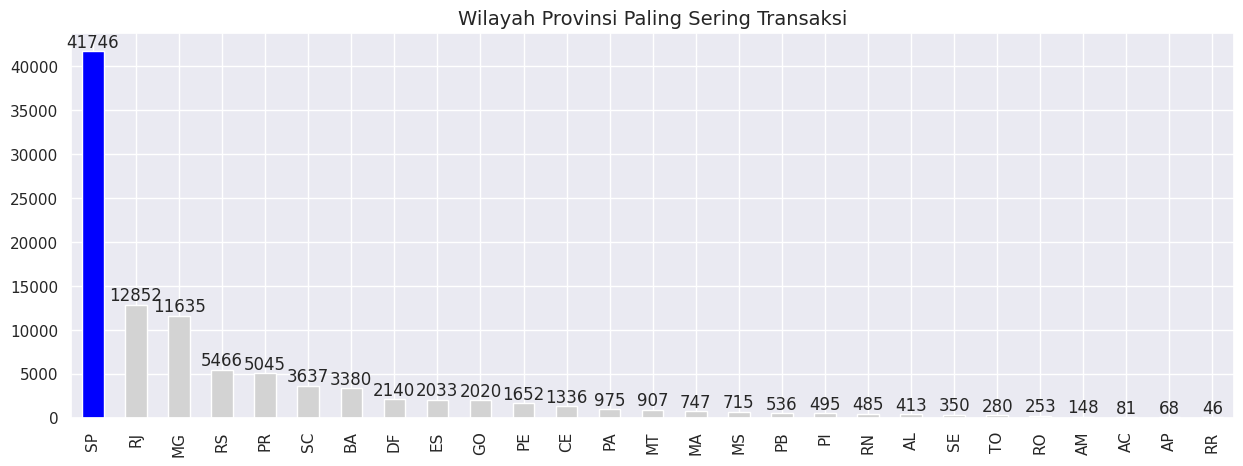

In [57]:
plot_frequency_data_kualitatif(df=customers_df, feature="customer_state", title="Wilayah Provinsi Paling Sering Transaksi", kind="bar", top_10=False, tail=False)

**Insight:**
- Pelanggan didominasi oleh negara bagian **SP  yang melonjak tinggi dibandingkan negara bagian lainnya, hampir 4 kali lipat dari negara bagian RJ

### Geolocation

In [58]:
count_cust_state = geolocation_df["geolocation_state"].value_counts()
count_cust_state

geolocation_state
SP    404268
MG    126336
RJ    121169
RS     61851
PR     57859
SC     38328
BA     36045
GO     20139
ES     16748
PE     16432
DF     12986
MT     12031
CE     11674
PA     10853
MS     10431
MA      7853
PB      5538
RN      5041
PI      4549
AL      4183
TO      3576
SE      3563
RO      3478
AM      2432
AC      1301
AP       853
RR       646
Name: count, dtype: int64

In [59]:
geolococation_state_grouped = geolocation_df.groupby('geolocation_state').agg({
    'geolocation_lat': 'mean', 'geolocation_lng': 'mean',
    'geolocation_city': 'first'
}).reset_index()
geolococation_state_grouped

geolocation_state  geolocation_lat  geolocation_lng       geolocation_city
0                 AC        -9.702555       -68.451852              sao paulo
1                 AL        -9.599729       -36.052017                 maceio
2                 AM        -3.349336       -60.537430                 manaus
3                 AP         0.086025       -51.234304                 macapa
4                 BA       -13.049361       -39.560649               salvador
5                 CE        -4.363151       -39.004140              fortaleza
6                 DF       -15.810885       -47.969630               brasilia
7                 ES       -20.105145       -40.503183                vitória
8                 GO       -16.577645       -49.334195              novo gama
9                 MA        -3.798997       -44.818627               sao luis
10                MG       -19.864647       -44.421615         belo horizonte
11                MS       -20.765006       -54.532140           campo grande
12                MT       -14.156482       -55.708956                 cuiabá
13                PA        -2.631213       -49.485862                  belem
14                PB        -7.088298       -35.821678            joao pessoa
15                PE        -8.179098       -35.758866                 recife
16                PI        -5.754989       -42.509541               teresina
17                PR       -24.793607       -50.879662               curitiba
18                RJ       -22.743477       -43.155540         rio de janeiro
19                RN        -5.856702       -35.990079              são paulo
20                RO       -10.341289       -62.720579            porto velho
21                RR         2.717100       -60.672866              boa vista
22                RS       -29.679191       -52.032652         nova andradina
23                SC       -27.222486       -49.617937  balneario de picarras
24                SE       -10.866199       -37.181169                aracaju
25                SP       -23.155308       -47.084074              sao paulo
26                TO        -9.503700       -48.348661                 palmas

In [60]:
geolococation_state_grouped = pd.merge(geolococation_state_grouped, count_cust_state, on="geolocation_state")
geolococation_state_grouped.rename(
    {"count": "count_cust"},
    axis=1,
    inplace=True
)
geolococation_state_grouped


geolocation_state  geolocation_lat  geolocation_lng       geolocation_city  \
0                 AC        -9.702555       -68.451852              sao paulo   
1                 AL        -9.599729       -36.052017                 maceio   
2                 AM        -3.349336       -60.537430                 manaus   
3                 AP         0.086025       -51.234304                 macapa   
4                 BA       -13.049361       -39.560649               salvador   
5                 CE        -4.363151       -39.004140              fortaleza   
6                 DF       -15.810885       -47.969630               brasilia   
7                 ES       -20.105145       -40.503183                vitória   
8                 GO       -16.577645       -49.334195              novo gama   
9                 MA        -3.798997       -44.818627               sao luis   
10                MG       -19.864647       -44.421615         belo horizonte   
11                MS       -20.765006       -54.532140           campo grande   
12                MT       -14.156482       -55.708956                 cuiabá   
13                PA        -2.631213       -49.485862                  belem   
14                PB        -7.088298       -35.821678            joao pessoa   
15                PE        -8.179098       -35.758866                 recife   
16                PI        -5.754989       -42.509541               teresina   
17                PR       -24.793607       -50.879662               curitiba   
18                RJ       -22.743477       -43.155540         rio de janeiro   
19                RN        -5.856702       -35.990079              são paulo   
20                RO       -10.341289       -62.720579            porto velho   
21                RR         2.717100       -60.672866              boa vista   
22                RS       -29.679191       -52.032652         nova andradina   
23                SC       -27.222486       -49.617937  balneario de picarras   
24                SE       -10.866199       -37.181169                aracaju   
25                SP       -23.155308       -47.084074              sao paulo   
26                TO        -9.503700       -48.348661                 palmas   

    count_cust  
0         1301  
1         4183  
2         2432  
3          853  
4        36045  
5        11674  
6        12986  
7        16748  
8        20139  
9         7853  
10      126336  
11       10431  
12       12031  
13       10853  
14        5538  
15       16432  
16        4549  
17       57859  
18      121169  
19        5041  
20        3478  
21         646  
22       61851  
23       38328  
24        3563  
25      404268  
26        3576

In [61]:
visualize_folium_map(geolococation_state_grouped, "geolocation_lat", "geolocation_lng")

### Order Items

In [62]:
order_items_df.head()

order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3  7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4  ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   

   shipping_limit_date   price  freight_value  
0  2017-09-19 09:45:35   58.90          13.29  
1  2017-05-03 11:05:13  239.90          19.93  
2  2018-01-18 14:48:30  199.00          17.87  
3  2018-08-15 10:10:18   12.99          12.79  
4  2017-02-13 13:57:51  199.90          18.14

In [63]:
order_items_df.describe()

order_item_id          price  freight_value
count  112650.000000  112650.000000  112650.000000
mean        1.197834     120.653739      19.990320
std         0.705124     183.633928      15.806405
min         1.000000       0.850000       0.000000
25%         1.000000      39.900000      13.080000
50%         1.000000      74.990000      16.260000
75%         1.000000     134.900000      21.150000
max        21.000000    6735.000000     409.680000

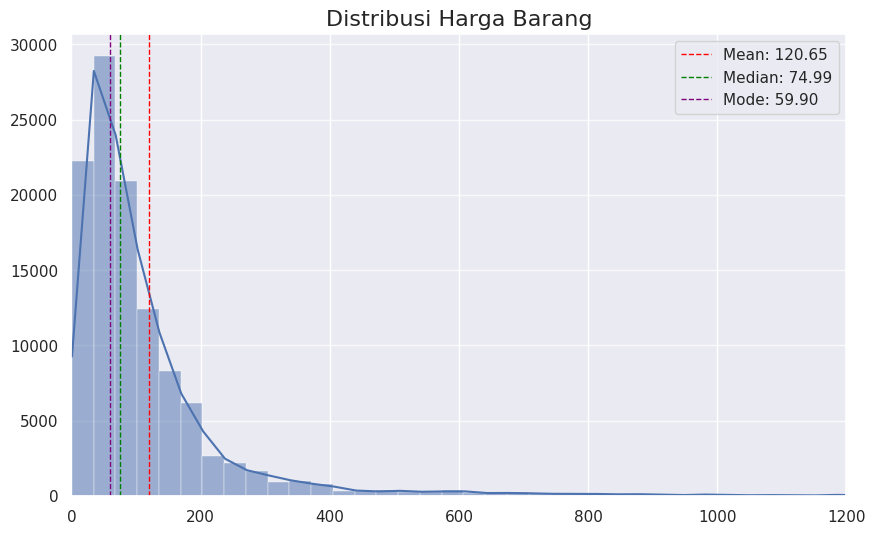

In [64]:
plot_distribution_data_kuantitatif(df=order_items_df, feature="price", title="Distribusi Harga Barang", x_lim=1200, bins=200)

**Insight:**
- Dari visualisasi mendapatkan hasil distribusi asimetris tlebih epatnya miring ke kenan (right-skewed), itu berarti harga barang memiliki harga yang relatif murah tetapi ada juga yang mahal namun sedikit.

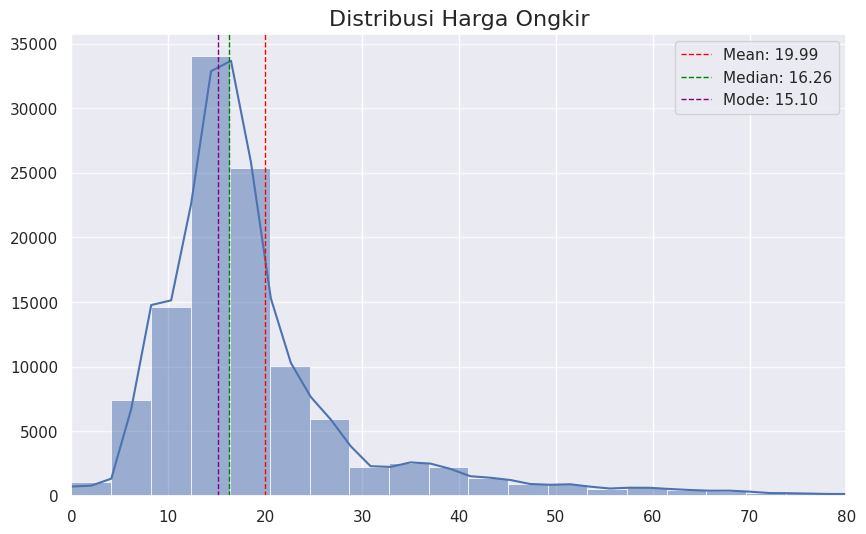

In [65]:
plot_distribution_data_kuantitatif(df=order_items_df, feature="freight_value", title="Distribusi Harga Ongkir", x_lim=80, bins=100)

**Insight:**
- Dari hasil visualisasi menunjukan distribusi cukup simetris namun masih memiliki sedikit ekor tebal dari sisi kanan (sedikit miring ke kanan) ini berarti pelanggan relatif dekat jaraknya dengan penjual karena harga ongkir barang ditentukan oleh jarak antara penjual dan pembeli

### Order Payments

In [66]:
order_payments_df.head()

order_id  payment_sequential payment_type  \
0  b81ef226f3fe1789b1e8b2acac839d17                   1  credit_card   
1  a9810da82917af2d9aefd1278f1dcfa0                   1  credit_card   
2  25e8ea4e93396b6fa0d3dd708e76c1bd                   1  credit_card   
3  ba78997921bbcdc1373bb41e913ab953                   1  credit_card   
4  42fdf880ba16b47b59251dd489d4441a                   1  credit_card   

   payment_installments  payment_value  
0                     8          99.33  
1                     1          24.39  
2                     1          65.71  
3                     8         107.78  
4                     2         128.45

In [67]:
order_payments_df.describe()

payment_sequential  payment_installments  payment_value
count       103886.000000         103886.000000  103886.000000
mean             1.092679              2.853368     154.100380
std              0.706584              2.687034     217.494064
min              1.000000              1.000000       0.000000
25%              1.000000              1.000000      56.790000
50%              1.000000              1.000000     100.000000
75%              1.000000              4.000000     171.837500
max             29.000000             24.000000   13664.080000

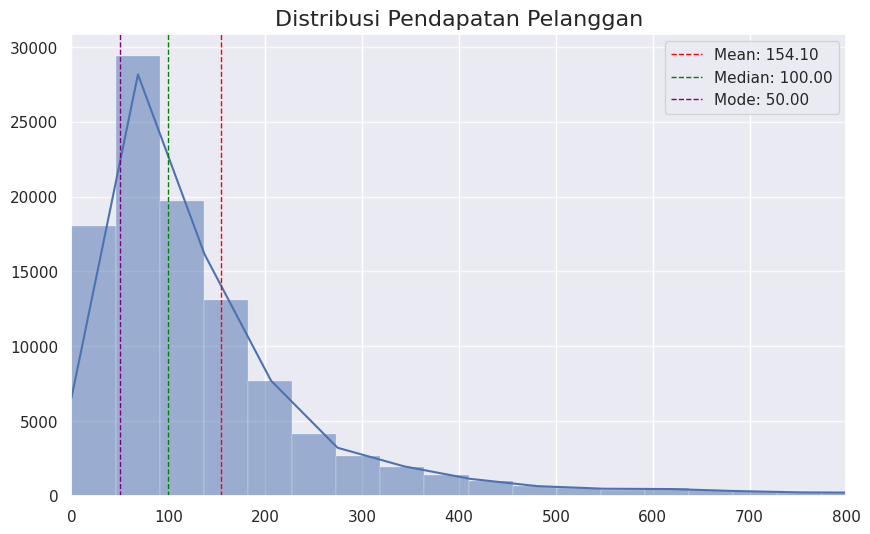

In [68]:
plot_distribution_data_kuantitatif(df=order_payments_df, feature="payment_value", title="Distribusi Pendapatan Pelanggan", x_lim=800, bins=300)

**Insight:**
- Hasil visualisasi menunjukan disribusi miring ke kanan (righ-skewed). Ini berarti sebagian pelanggan memiliki pendapatan yang rendah tapi ada juga yang memiliki pendapatan tinggi (sultan) tapi sedikit.
- Pendapatan pelanggan dominan berada di rata-rata 154

In [69]:
order_payments_df

order_id  payment_sequential payment_type  \
0       b81ef226f3fe1789b1e8b2acac839d17                   1  credit_card   
1       a9810da82917af2d9aefd1278f1dcfa0                   1  credit_card   
2       25e8ea4e93396b6fa0d3dd708e76c1bd                   1  credit_card   
3       ba78997921bbcdc1373bb41e913ab953                   1  credit_card   
4       42fdf880ba16b47b59251dd489d4441a                   1  credit_card   
...                                  ...                 ...          ...   
103881  0406037ad97740d563a178ecc7a2075c                   1       boleto   
103882  7b905861d7c825891d6347454ea7863f                   1  credit_card   
103883  32609bbb3dd69b3c066a6860554a77bf                   1  credit_card   
103884  b8b61059626efa996a60be9bb9320e10                   1  credit_card   
103885  28bbae6599b09d39ca406b747b6632b1                   1       boleto   

        payment_installments  payment_value  
0                          8          99.33  
1                          1          24.39  
2                          1          65.71  
3                          8         107.78  
4                          2         128.45  
...                      ...            ...  
103881                     1         363.31  
103882                     2          96.80  
103883                     1          47.77  
103884                     5         369.54  
103885                     1         191.58  

[103886 rows x 5 columns]

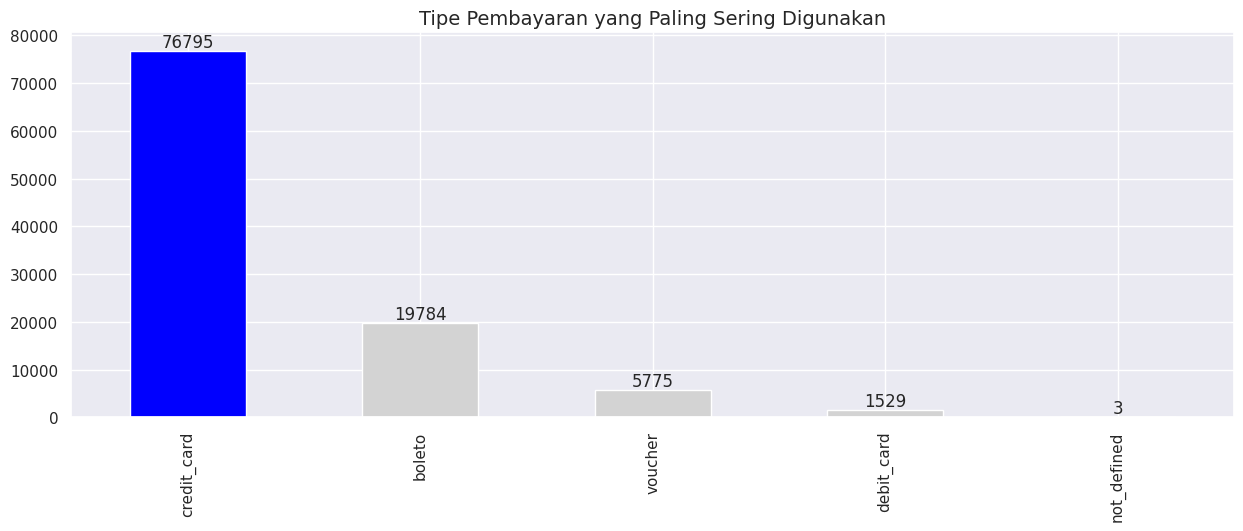

In [70]:
plot_frequency_data_kualitatif(df=order_payments_df, feature="payment_type", title="Tipe Pembayaran yang Paling Sering Digunakan", kind="bar", top_10=True, tail=False)

**Insight:**
- Pelanggan dominan melakukan pembayaran dengan tipe kartu kredit dibandingkan tipe pembayaran lainnya. Ini bisa disebabkan karena penghasilan pelanggan rendah hal ini sejalan dengan distribusi dari pendapatan pelanggan.

### Customers - Orders

In [71]:
customers_df

customer_id                customer_unique_id  \
0      06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1      18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2      4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3      b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4      4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   
...                                 ...                               ...   
99436  17ddf5dd5d51696bb3d7c6291687be6f  1a29b476fee25c95fbafc67c5ac95cf8   
99437  e7b71a9017aa05c9a7fd292d714858e8  d52a67c98be1cf6a5c84435bd38d095d   
99438  5e28dfe12db7fb50a4b2f691faecea5e  e9f50caf99f032f0bf3c55141f019d99   
99439  56b18e2166679b8a959d72dd06da27f9  73c2643a0a458b49f58cea58833b192e   
99440  274fa6071e5e17fe303b9748641082c8  84732c5050c01db9b23e19ba39899398   

       customer_zip_code_prefix          customer_city customer_state  
0                         14409                 franca             SP  
1                          9790  sao bernardo do campo             SP  
2                          1151              sao paulo             SP  
3                          8775        mogi das cruzes             SP  
4                         13056               campinas             SP  
...                         ...                    ...            ...  
99436                      3937              sao paulo             SP  
99437                      6764        taboao da serra             SP  
99438                     60115              fortaleza             CE  
99439                     92120                 canoas             RS  
99440                      6703                  cotia             SP  

[99441 rows x 5 columns]

In [72]:
orders_df

order_id                       customer_id  \
0      e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1      53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2      47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3      949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4      ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   
...                                 ...                               ...   
99436  9c5dedf39a927c1b2549525ed64a053c  39bd1228ee8140590ac3aca26f2dfe00   
99437  63943bddc261676b46f01ca7ac2f7bd8  1fca14ff2861355f6e5f14306ff977a7   
99438  83c1379a015df1e13d02aae0204711ab  1aa71eb042121263aafbe80c1b562c9c   
99439  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
99440  66dea50a8b16d9b4dee7af250b4be1a5  edb027a75a1449115f6b43211ae02a24   

      order_status order_purchase_timestamp    order_approved_at  \
0        delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1        delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2        delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3        delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4        delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   
...            ...                      ...                  ...   
99436    delivered      2017-03-09 09:54:05  2017-03-09 09:54:05   
99437    delivered      2018-02-06 12:58:58  2018-02-06 13:10:37   
99438    delivered      2017-08-27 14:46:43  2017-08-27 15:04:16   
99439    delivered      2018-01-08 21:28:27  2018-01-08 21:36:21   
99440    delivered      2018-03-08 20:57:30  2018-03-09 11:20:28   

      order_delivered_carrier_date order_delivered_customer_date  \
0              2017-10-04 19:55:00           2017-10-10 21:25:13   
1              2018-07-26 14:31:00           2018-08-07 15:27:45   
2              2018-08-08 13:50:00           2018-08-17 18:06:29   
3              2017-11-22 13:39:59           2017-12-02 00:28:42   
4              2018-02-14 19:46:34           2018-02-16 18:17:02   
...                            ...                           ...   
99436          2017-03-10 11:18:03           2017-03-17 15:08:01   
99437          2018-02-07 23:22:42           2018-02-28 17:37:56   
99438          2017-08-28 20:52:26           2017-09-21 11:24:17   
99439          2018-01-12 15:35:03           2018-01-25 23:32:54   
99440          2018-03-09 22:11:59           2018-03-16 13:08:30   

      order_estimated_delivery_date  
0               2017-10-18 00:00:00  
1               2018-08-13 00:00:00  
2               2018-09-04 00:00:00  
3               2017-12-15 00:00:00  
4               2018-02-26 00:00:00  
...                             ...  
99436           2017-03-28 00:00:00  
99437           2018-03-02 00:00:00  
99438           2017-09-27 00:00:00  
99439           2018-02-15 00:00:00  
99440           2018-04-03 00:00:00  

[99441 rows x 8 columns]

In [73]:
customers_orders_df = pd.merge(
    left=customers_df,
    right=orders_df,
    how="inner",
    left_on="customer_id",
    right_on="customer_id"
)
customers_orders_df

customer_id                customer_unique_id  \
0      06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1      18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2      4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3      b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4      4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   
...                                 ...                               ...   
99436  17ddf5dd5d51696bb3d7c6291687be6f  1a29b476fee25c95fbafc67c5ac95cf8   
99437  e7b71a9017aa05c9a7fd292d714858e8  d52a67c98be1cf6a5c84435bd38d095d   
99438  5e28dfe12db7fb50a4b2f691faecea5e  e9f50caf99f032f0bf3c55141f019d99   
99439  56b18e2166679b8a959d72dd06da27f9  73c2643a0a458b49f58cea58833b192e   
99440  274fa6071e5e17fe303b9748641082c8  84732c5050c01db9b23e19ba39899398   

       customer_zip_code_prefix          customer_city customer_state  \
0                         14409                 franca             SP   
1                          9790  sao bernardo do campo             SP   
2                          1151              sao paulo             SP   
3                          8775        mogi das cruzes             SP   
4                         13056               campinas             SP   
...                         ...                    ...            ...   
99436                      3937              sao paulo             SP   
99437                      6764        taboao da serra             SP   
99438                     60115              fortaleza             CE   
99439                     92120                 canoas             RS   
99440                      6703                  cotia             SP   

                               order_id order_status order_purchase_timestamp  \
0      00e7ee1b050b8499577073aeb2a297a1    delivered      2017-05-16 15:05:35   
1      29150127e6685892b6eab3eec79f59c7    delivered      2018-01-12 20:48:24   
2      b2059ed67ce144a36e2aa97d2c9e9ad2    delivered      2018-05-19 16:07:45   
3      951670f92359f4fe4a63112aa7306eba    delivered      2018-03-13 16:06:38   
4      6b7d50bd145f6fc7f33cebabd7e49d0f    delivered      2018-07-29 09:51:30   
...                                 ...          ...                      ...   
99436  6760e20addcf0121e9d58f2f1ff14298    delivered      2018-04-07 15:48:17   
99437  9ec0c8947d973db4f4e8dcf1fbfa8f1b    delivered      2018-04-04 08:20:22   
99438  fed4434add09a6f332ea398efd656a5c    delivered      2018-04-08 20:11:50   
99439  e31ec91cea1ecf97797787471f98a8c2    delivered      2017-11-03 21:08:33   
99440  28db69209a75e59f20ccbb5c36a20b90    delivered      2017-12-19 14:27:23   

         order_approved_at order_delivered_carrier_date  \
0      2017-05-16 15:22:12          2017-05-23 10:47:57   
1      2018-01-12 20:58:32          2018-01-15 17:14:59   
2      2018-05-20 16:19:10          2018-06-11 14:31:00   
3      2018-03-13 17:29:19          2018-03-27 23:22:42   
4      2018-07-29 10:10:09          2018-07-30 15:16:00   
...                    ...                          ...   
99436  2018-04-07 16:08:45          2018-04-11 02:08:36   
99437  2018-04-04 08:35:12          2018-04-05 18:42:35   
99438  2018-04-08 20:30:03          2018-04-09 17:52:17   
99439  2017-11-03 21:31:20          2017-11-06 18:24:41   
99440  2017-12-19 18:50:39          2017-12-21 19:17:21   

      order_delivered_customer_date order_estimated_delivery_date  
0               2017-05-25 10:35:35           2017-06-05 00:00:00  
1               2018-01-29 12:41:19           2018-02-06 00:00:00  
2               2018-06-14 17:58:51           2018-06-13 00:00:00  
3               2018-03-28 16:04:25           2018-04-10 00:00:00  
4               2018-08-09 20:55:48           2018-08-15 00:00:00  
...                             ...                           ...  
99436           2018-04-13 20:06:37           2018-04-25 00:00:00  


In [74]:
customers_orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   customer_id                    99441 non-null  object        
 1   customer_unique_id             99441 non-null  object        
 2   customer_zip_code_prefix       99441 non-null  int64         
 3   customer_city                  99441 non-null  object        
 4   customer_state                 99441 non-null  object        
 5   order_id                       99441 non-null  object        
 6   order_status                   99441 non-null  object        
 7   order_purchase_timestamp       99441 non-null  datetime64[ns]
 8   order_approved_at              99281 non-null  object        
 9   order_delivered_carrier_date   97658 non-null  object        
 10  order_delivered_customer_date  96476 non-null  object        
 11  order_estimated

In [75]:
customers_orders_df['purchase_month'] = customers_orders_df['order_purchase_timestamp'].dt.month
customers_orders_df['is_weekend'] = customers_orders_df['order_purchase_timestamp'].dt.dayofweek.apply(lambda x: "Ya" if x >= 5 else "Tidak")
customers_orders_df.head()

customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  \
0                     14409                 franca             SP   
1                      9790  sao bernardo do campo             SP   
2                      1151              sao paulo             SP   
3                      8775        mogi das cruzes             SP   
4                     13056               campinas             SP   

                           order_id order_status order_purchase_timestamp  \
0  00e7ee1b050b8499577073aeb2a297a1    delivered      2017-05-16 15:05:35   
1  29150127e6685892b6eab3eec79f59c7    delivered      2018-01-12 20:48:24   
2  b2059ed67ce144a36e2aa97d2c9e9ad2    delivered      2018-05-19 16:07:45   
3  951670f92359f4fe4a63112aa7306eba    delivered      2018-03-13 16:06:38   
4  6b7d50bd145f6fc7f33cebabd7e49d0f    delivered      2018-07-29 09:51:30   

     order_approved_at order_delivered_carrier_date  \
0  2017-05-16 15:22:12          2017-05-23 10:47:57   
1  2018-01-12 20:58:32          2018-01-15 17:14:59   
2  2018-05-20 16:19:10          2018-06-11 14:31:00   
3  2018-03-13 17:29:19          2018-03-27 23:22:42   
4  2018-07-29 10:10:09          2018-07-30 15:16:00   

  order_delivered_customer_date order_estimated_delivery_date  purchase_month  \
0           2017-05-25 10:35:35           2017-06-05 00:00:00               5   
1           2018-01-29 12:41:19           2018-02-06 00:00:00               1   
2           2018-06-14 17:58:51           2018-06-13 00:00:00               5   
3           2018-03-28 16:04:25           2018-04-10 00:00:00               3   
4           2018-08-09 20:55:48           2018-08-15 00:00:00               7   

  is_weekend  
0      Tidak  
1      Tidak  
2         Ya  
3      Tidak  
4         Ya

In [76]:
map_month = {
    1: "Januari",
    2: "Februari",
    3: "Maret",
    4: "April",
    5: "Mei",
    6: "Juni",
    7: "Juli",
    8: "Agustus",
    9: "September",
    10: "Oktober",
    11: "November",
    12: "Desember"
}
customers_orders_df["purchase_month"] = customers_orders_df["purchase_month"].map(map_month)
customers_orders_df.head()

customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  \
0                     14409                 franca             SP   
1                      9790  sao bernardo do campo             SP   
2                      1151              sao paulo             SP   
3                      8775        mogi das cruzes             SP   
4                     13056               campinas             SP   

                           order_id order_status order_purchase_timestamp  \
0  00e7ee1b050b8499577073aeb2a297a1    delivered      2017-05-16 15:05:35   
1  29150127e6685892b6eab3eec79f59c7    delivered      2018-01-12 20:48:24   
2  b2059ed67ce144a36e2aa97d2c9e9ad2    delivered      2018-05-19 16:07:45   
3  951670f92359f4fe4a63112aa7306eba    delivered      2018-03-13 16:06:38   
4  6b7d50bd145f6fc7f33cebabd7e49d0f    delivered      2018-07-29 09:51:30   

     order_approved_at order_delivered_carrier_date  \
0  2017-05-16 15:22:12          2017-05-23 10:47:57   
1  2018-01-12 20:58:32          2018-01-15 17:14:59   
2  2018-05-20 16:19:10          2018-06-11 14:31:00   
3  2018-03-13 17:29:19          2018-03-27 23:22:42   
4  2018-07-29 10:10:09          2018-07-30 15:16:00   

  order_delivered_customer_date order_estimated_delivery_date purchase_month  \
0           2017-05-25 10:35:35           2017-06-05 00:00:00            Mei   
1           2018-01-29 12:41:19           2018-02-06 00:00:00        Januari   
2           2018-06-14 17:58:51           2018-06-13 00:00:00            Mei   
3           2018-03-28 16:04:25           2018-04-10 00:00:00          Maret   
4           2018-08-09 20:55:48           2018-08-15 00:00:00           Juli   

  is_weekend  
0      Tidak  
1      Tidak  
2         Ya  
3      Tidak  
4         Ya

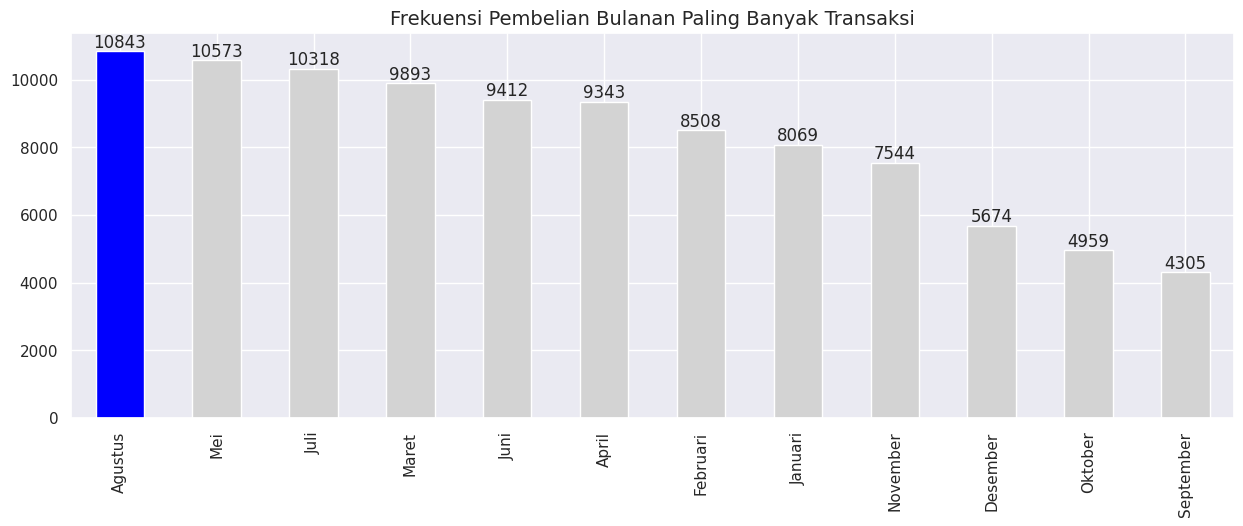

In [77]:
plot_frequency_data_kualitatif(df=customers_orders_df, feature="purchase_month", title="Frekuensi Pembelian Bulanan Paling Banyak Transaksi", kind="bar", top_10=False, tail=False)

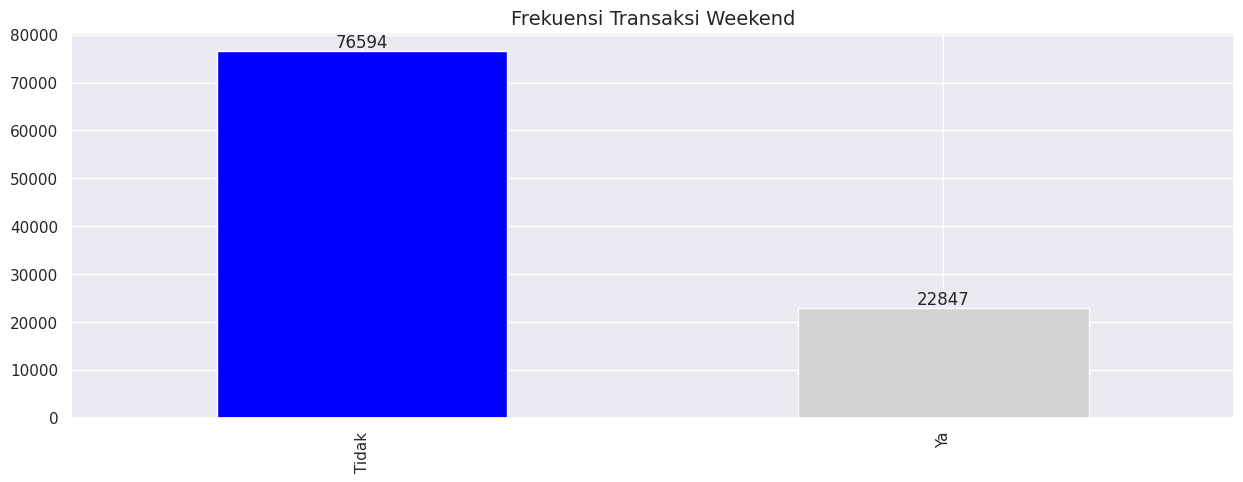

In [78]:
plot_frequency_data_kualitatif(df=customers_orders_df, feature="is_weekend", title="Frekuensi Transaksi Weekend", kind="bar", top_10=False, tail=False)

**Insight:**
- Bulan Agustus pesanan membludak, ini mungkin bisa disebabkan karena ada diskon besar-besaran atau promo voucher, sehingga pada bulan september pesanan turun sangat drastis karena tidak ada promo atau diskon yang sedang berlangsung atau masa diskon sudah habis
- Dari hasil visualisasi memberitahu kita bahwa hari weekend atau jam normal kantor pesanan paling banyak dibandingkan hari weekend.

### Customers Orders - Order Items

In [79]:
order_items_df

order_id  order_item_id  \
0       00010242fe8c5a6d1ba2dd792cb16214              1   
1       00018f77f2f0320c557190d7a144bdd3              1   
2       000229ec398224ef6ca0657da4fc703e              1   
3       00024acbcdf0a6daa1e931b038114c75              1   
4       00042b26cf59d7ce69dfabb4e55b4fd9              1   
...                                  ...            ...   
112645  fffc94f6ce00a00581880bf54a75a037              1   
112646  fffcd46ef2263f404302a634eb57f7eb              1   
112647  fffce4705a9662cd70adb13d4a31832d              1   
112648  fffe18544ffabc95dfada21779c9644f              1   
112649  fffe41c64501cc87c801fd61db3f6244              1   

                              product_id                         seller_id  \
0       4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1       e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2       c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3       7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4       ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   
...                                  ...                               ...   
112645  4aa6014eceb682077f9dc4bffebc05b0  b8bc237ba3788b23da09c0f1f3a3288c   
112646  32e07fd915822b0765e448c4dd74c828  f3c38ab652836d21de61fb8314b69182   
112647  72a30483855e2eafc67aee5dc2560482  c3cfdc648177fdbbbb35635a37472c53   
112648  9c422a519119dcad7575db5af1ba540e  2b3e4a2a3ea8e01938cabda2a3e5cc79   
112649  350688d9dc1e75ff97be326363655e01  f7ccf836d21b2fb1de37564105216cc1   

        shipping_limit_date   price  freight_value  
0       2017-09-19 09:45:35   58.90          13.29  
1       2017-05-03 11:05:13  239.90          19.93  
2       2018-01-18 14:48:30  199.00          17.87  
3       2018-08-15 10:10:18   12.99          12.79  
4       2017-02-13 13:57:51  199.90          18.14  
...                     ...     ...            ...  
112645  2018-05-02 04:11:01  299.99          43.41  
112646  2018-07-20 04:31:48  350.00          36.53  
112647  2017-10-30 17:14:25   99.90          16.95  
112648  2017-08-21 00:04:32   55.99           8.72  
112649  2018-06-12 17:10:13   43.00          12.79  

[112650 rows x 7 columns]

In [80]:
customers_orders_order_items_df = pd.merge(
    left=customers_orders_df,
    right=order_items_df,
    how="inner",
    left_on="order_id",
    right_on="order_id"
)
customers_orders_order_items_df

customer_id                customer_unique_id  \
0       06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1       18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2       4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3       b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4       4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   
...                                  ...                               ...   
112645  17ddf5dd5d51696bb3d7c6291687be6f  1a29b476fee25c95fbafc67c5ac95cf8   
112646  e7b71a9017aa05c9a7fd292d714858e8  d52a67c98be1cf6a5c84435bd38d095d   
112647  5e28dfe12db7fb50a4b2f691faecea5e  e9f50caf99f032f0bf3c55141f019d99   
112648  56b18e2166679b8a959d72dd06da27f9  73c2643a0a458b49f58cea58833b192e   
112649  274fa6071e5e17fe303b9748641082c8  84732c5050c01db9b23e19ba39899398   

        customer_zip_code_prefix          customer_city customer_state  \
0                          14409                 franca             SP   
1                           9790  sao bernardo do campo             SP   
2                           1151              sao paulo             SP   
3                           8775        mogi das cruzes             SP   
4                          13056               campinas             SP   
...                          ...                    ...            ...   
112645                      3937              sao paulo             SP   
112646                      6764        taboao da serra             SP   
112647                     60115              fortaleza             CE   
112648                     92120                 canoas             RS   
112649                      6703                  cotia             SP   

                                order_id order_status  \
0       00e7ee1b050b8499577073aeb2a297a1    delivered   
1       29150127e6685892b6eab3eec79f59c7    delivered   
2       b2059ed67ce144a36e2aa97d2c9e9ad2    delivered   
3       951670f92359f4fe4a63112aa7306eba    delivered   
4       6b7d50bd145f6fc7f33cebabd7e49d0f    delivered   
...                                  ...          ...   
112645  6760e20addcf0121e9d58f2f1ff14298    delivered   
112646  9ec0c8947d973db4f4e8dcf1fbfa8f1b    delivered   
112647  fed4434add09a6f332ea398efd656a5c    delivered   
112648  e31ec91cea1ecf97797787471f98a8c2    delivered   
112649  28db69209a75e59f20ccbb5c36a20b90    delivered   

       order_purchase_timestamp    order_approved_at  \
0           2017-05-16 15:05:35  2017-05-16 15:22:12   
1           2018-01-12 20:48:24  2018-01-12 20:58:32   
2           2018-05-19 16:07:45  2018-05-20 16:19:10   
3           2018-03-13 16:06:38  2018-03-13 17:29:19   
4           2018-07-29 09:51:30  2018-07-29 10:10:09   
...                         ...                  ...   
112645      2018-04-07 15:48:17  2018-04-07 16:08:45   
112646      2018-04-04 08:20:22  2018-04-04 08:35:12   
112647      2018-04-08 20:11:50  2018-04-08 20:30:03   
112648      2017-11-03 21:08:33  2017-11-03 21:31:20   
112649      2017-12-19 14:27:23  2017-12-19 18:50:39   

       order_delivered_carrier_date order_delivered_customer_date  \
0               2017-05-23 10:47:57           2017-05-25 10:35:35   
1               2018-01-15 17:14:59           2018-01-29 12:41:19   
2               2018-06-11 14:31:00           2018-06-14 17:58:51   
3               2018-03-27 23:22:42           2018-03-28 16:04:25   
4               2018-07-30 15:16:00           2018-08-09 20:55:48   
...                             ...                           ...   
112645          2018-04-11 02:08:36           2018-04-13 20:06:37   
112646          2018-04-05 18:42:35           2018-04-11 18:54:45   
112647          2018-04-09 17:52:17           2018-05-09 19:03:15   
112648          2017-11-06 18:24:41           2017-11-16 19:58:39   
112649          2017-12-21 19:17:21           2017-12-26 18:42:36   

       order_est

### Customers Orders - Order Items - Order Payments

In [81]:
order_payments_df.head()

order_id  payment_sequential payment_type  \
0  b81ef226f3fe1789b1e8b2acac839d17                   1  credit_card   
1  a9810da82917af2d9aefd1278f1dcfa0                   1  credit_card   
2  25e8ea4e93396b6fa0d3dd708e76c1bd                   1  credit_card   
3  ba78997921bbcdc1373bb41e913ab953                   1  credit_card   
4  42fdf880ba16b47b59251dd489d4441a                   1  credit_card   

   payment_installments  payment_value  
0                     8          99.33  
1                     1          24.39  
2                     1          65.71  
3                     8         107.78  
4                     2         128.45

In [82]:
customers_orders_order_payments_df = pd.merge(
    left=customers_orders_df,
    right=order_payments_df,
    how="inner",
    left_on="order_id",
    right_on="order_id"
)
customers_orders_order_payments_df.head()

customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  \
0                     14409                 franca             SP   
1                      9790  sao bernardo do campo             SP   
2                      1151              sao paulo             SP   
3                      8775        mogi das cruzes             SP   
4                     13056               campinas             SP   

                           order_id order_status order_purchase_timestamp  \
0  00e7ee1b050b8499577073aeb2a297a1    delivered      2017-05-16 15:05:35   
1  29150127e6685892b6eab3eec79f59c7    delivered      2018-01-12 20:48:24   
2  b2059ed67ce144a36e2aa97d2c9e9ad2    delivered      2018-05-19 16:07:45   
3  951670f92359f4fe4a63112aa7306eba    delivered      2018-03-13 16:06:38   
4  6b7d50bd145f6fc7f33cebabd7e49d0f    delivered      2018-07-29 09:51:30   

     order_approved_at order_delivered_carrier_date  \
0  2017-05-16 15:22:12          2017-05-23 10:47:57   
1  2018-01-12 20:58:32          2018-01-15 17:14:59   
2  2018-05-20 16:19:10          2018-06-11 14:31:00   
3  2018-03-13 17:29:19          2018-03-27 23:22:42   
4  2018-07-29 10:10:09          2018-07-30 15:16:00   

  order_delivered_customer_date order_estimated_delivery_date purchase_month  \
0           2017-05-25 10:35:35           2017-06-05 00:00:00            Mei   
1           2018-01-29 12:41:19           2018-02-06 00:00:00        Januari   
2           2018-06-14 17:58:51           2018-06-13 00:00:00            Mei   
3           2018-03-28 16:04:25           2018-04-10 00:00:00          Maret   
4           2018-08-09 20:55:48           2018-08-15 00:00:00           Juli   

  is_weekend  payment_sequential payment_type  payment_installments  \
0      Tidak                   1  credit_card                     2   
1      Tidak                   1  credit_card                     8   
2         Ya                   1  credit_card                     7   
3      Tidak                   1  credit_card                     1   
4         Ya                   1  credit_card                     8   

   payment_value  
0         146.87  
1         335.48  
2         157.73  
3         173.30  
4         252.25

In [83]:
customers_orders_order_payments_df.describe()

customer_zip_code_prefix       order_purchase_timestamp  \
count             103886.000000                         103886   
mean               35072.550555  2017-12-29 21:48:47.671803648   
min                 1003.000000            2016-09-04 21:15:19   
25%                11366.250000  2017-09-10 09:01:08.750000128   
50%                24360.000000            2018-01-17 14:07:54   
75%                58418.000000  2018-05-03 18:35:58.249999872   
max                99990.000000            2018-10-17 17:30:18   
std                29743.491677                            NaN   

       payment_sequential  payment_installments  payment_value  
count       103886.000000         103886.000000  103886.000000  
mean             1.092679              2.853368     154.100380  
min              1.000000              1.000000       0.000000  
25%              1.000000              1.000000      56.790000  
50%              1.000000              1.000000     100.000000  
75%              1.000000              4.000000     171.837500  
max             29.000000             24.000000   13664.080000  
std              0.706584              2.687034     217.494064

In [84]:
bins = [0, 500, 2500, 8000, 14000]
labels = [
    "Low Spender",
    "Medium Spender",
    "High Spender",
    "Konglomerat Spender"
]

customers_orders_order_payments_df["spending_category"] = pd.cut(
    customers_orders_order_payments_df["payment_value"],
    bins=bins,
    labels=labels,
    include_lowest=True
)
customers_orders_order_payments_df.head()


customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  \
0                     14409                 franca             SP   
1                      9790  sao bernardo do campo             SP   
2                      1151              sao paulo             SP   
3                      8775        mogi das cruzes             SP   
4                     13056               campinas             SP   

                           order_id order_status order_purchase_timestamp  \
0  00e7ee1b050b8499577073aeb2a297a1    delivered      2017-05-16 15:05:35   
1  29150127e6685892b6eab3eec79f59c7    delivered      2018-01-12 20:48:24   
2  b2059ed67ce144a36e2aa97d2c9e9ad2    delivered      2018-05-19 16:07:45   
3  951670f92359f4fe4a63112aa7306eba    delivered      2018-03-13 16:06:38   
4  6b7d50bd145f6fc7f33cebabd7e49d0f    delivered      2018-07-29 09:51:30   

     order_approved_at order_delivered_carrier_date  \
0  2017-05-16 15:22:12          2017-05-23 10:47:57   
1  2018-01-12 20:58:32          2018-01-15 17:14:59   
2  2018-05-20 16:19:10          2018-06-11 14:31:00   
3  2018-03-13 17:29:19          2018-03-27 23:22:42   
4  2018-07-29 10:10:09          2018-07-30 15:16:00   

  order_delivered_customer_date order_estimated_delivery_date purchase_month  \
0           2017-05-25 10:35:35           2017-06-05 00:00:00            Mei   
1           2018-01-29 12:41:19           2018-02-06 00:00:00        Januari   
2           2018-06-14 17:58:51           2018-06-13 00:00:00            Mei   
3           2018-03-28 16:04:25           2018-04-10 00:00:00          Maret   
4           2018-08-09 20:55:48           2018-08-15 00:00:00           Juli   

  is_weekend  payment_sequential payment_type  payment_installments  \
0      Tidak                   1  credit_card                     2   
1      Tidak                   1  credit_card                     8   
2         Ya                   1  credit_card                     7   
3      Tidak                   1  credit_card                     1   
4         Ya                   1  credit_card                     8   

   payment_value spending_category  
0         146.87       Low Spender  
1         335.48       Low Spender  
2         157.73       Low Spender  
3         173.30       Low Spender  
4         252.25       Low Spender

**Insight:**
- Kita akan melakukan pengelompokan segmentasi pelanggan berdasarkan atribut payment_value yaitu pendapatan dari pelanggan dengan kategori Low Spender (jarang berbelanja), Medium Spender (pelanggan reguler), High Spender (daya beli tinggi), dan Konglomerat (top pelanggan) tujuannya untuk memudahkan analisis lebih lanjut secara mendalam

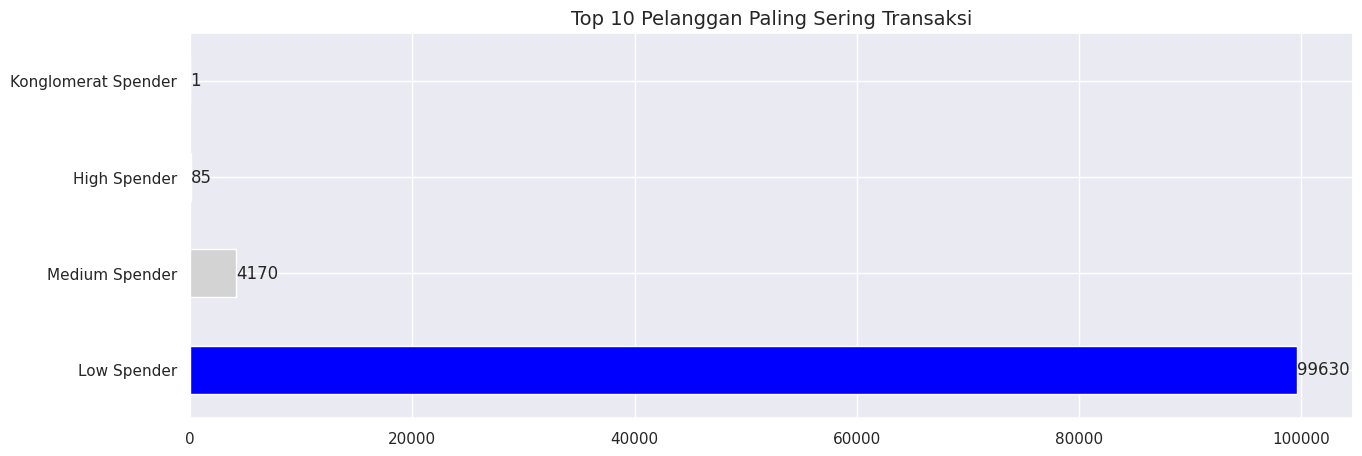

In [85]:
plot_frequency_data_kualitatif(df=customers_orders_order_payments_df, feature="spending_category", title="Top 10 Pelanggan Paling Sering Transaksi", kind="barh", top_10=True, tail=False)

**Insight:**
- Hasil menampilkan bahwa transaksi yang dominan adalah kelas low spender (pelanggan dengan pendapatan kecil diantara rentang 0 s/d 500). Ini berarti segmentasi pelanggan pendapatan cenderung hanya cukup untuk kebutuhan pokok saja dibandingkan membeli berbelanja. Namun disisi lain ada juga dengan pendapatan yang sangat kaya (kongolomerat) tetapi hanya berbelanja 1 kali saja mungkin disebabkan karena faktor apa yang diperlukan (diperusahaan/toko) sudah ia miliki sebelumnya, sehingga ia tidak perlu membeli produk lagi.

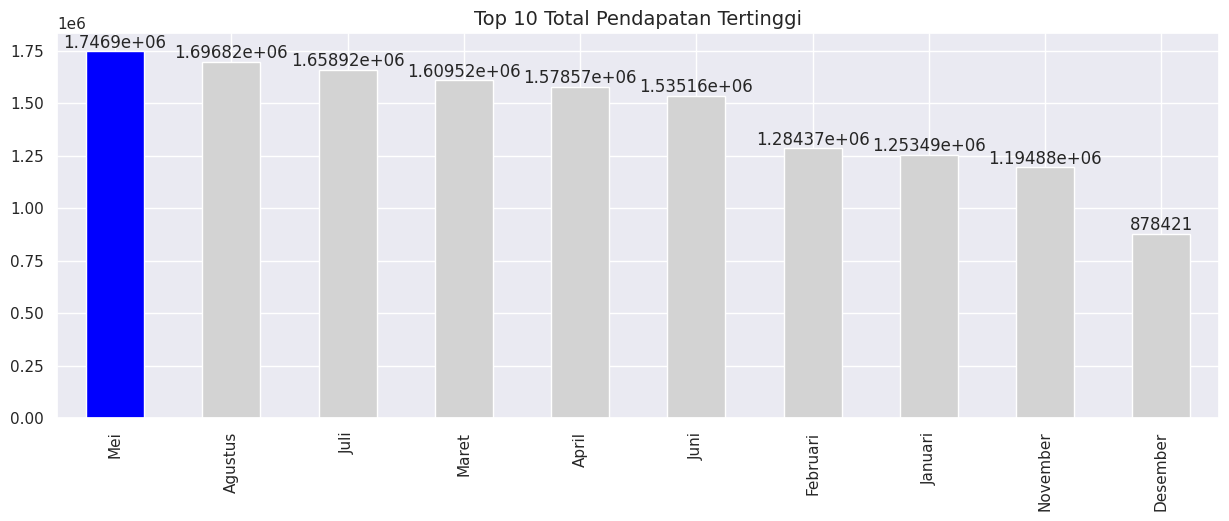

In [86]:
plot_sum_grouped_data_kuantitatif(df=customers_orders_order_payments_df, features="purchase_month", values="payment_value", title="Top 10 Total Pendapatan Tertinggi", kind="bar", top_10=True, tail=False)

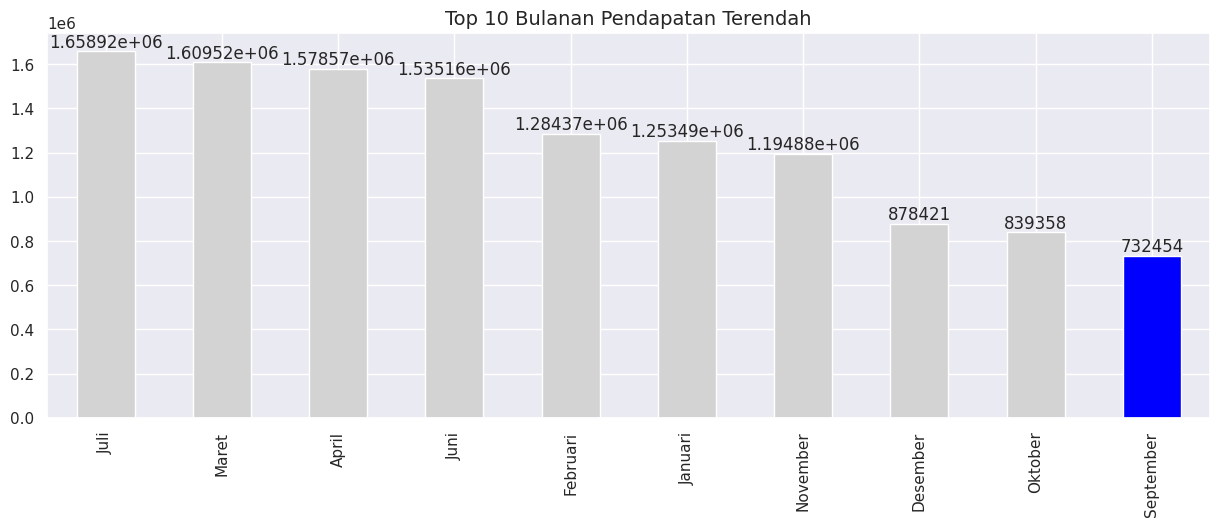

In [87]:
plot_sum_grouped_data_kuantitatif(df=customers_orders_order_payments_df, features="purchase_month", values="payment_value", title="Top 10 Bulanan Pendapatan Terendah", kind="bar", top_10=True, tail=True)

**Insight:**
- Pendapatan yang paling menguntungkan ada pada bulan Mei. Lain hal dengan pesanan membludak ada pada bulan Agustus ini berarti pesanan banyak belum tentu pendapatan tinggi hal ini mungkin ada beberapa faktor eksternal misalnya pada bulan Mei pelanggan lebih sering berbelanja barang mahal dibandingkan barang murah. Sedangkan untuk pendapatan terendah masih tetap sama ada di bulan September

In [88]:
canceled_grouped = customers_orders_order_payments_df[customers_orders_order_payments_df["order_status"] == "canceled"]
canceled_grouped.head()

customer_id                customer_unique_id  \
48   f34a6e874087ec1f0e3dab9fdf659c5d  233896de79986082f1f479f1f85281cb   
393  3ba47b09546c2da91ef141efce2d5888  b8c37ee810b38c416022e1c9f51e740c   
395  cfffbb322333151f8df6398a8c3340db  0dc0731aafd5659410244092b0dc7d65   
424  ffaded93e5a1fce06363cfb6905676a1  587b326ba3bf8aa4d3e50fb1f38ea79f   
917  c8223f76047e09bea798462f2f46ffa9  b4ee22e08cdaeab0b8e6bf2e67d7c19b   

     customer_zip_code_prefix customer_city customer_state  \
48                      38300     ituiutaba             MG   
393                     32140      contagem             MG   
395                      5093     sao paulo             SP   
424                      6722         cotia             SP   
917                     45690           una             BA   

                             order_id order_status order_purchase_timestamp  \
48   6e98de3a85c84ead6689189b825d35b5     canceled      2018-03-15 10:07:02   
393  a402af38a74c44926247db438245d95c     canceled      2018-01-30 22:12:10   
395  f63cd97f8f1db2eb266fb3bc2b4a95f3     canceled      2017-06-19 14:07:04   
424  5bca61e411c4fcce08327a8efc371911     canceled      2018-06-13 20:52:10   
917  5b4858f2dcf69731f2285a38829bfa7c     canceled      2018-02-15 20:53:17   

       order_approved_at order_delivered_carrier_date  \
48   2018-03-15 10:29:33                          NaN   
393  2018-01-30 22:34:14                          NaN   
395  2017-06-19 14:23:18                          NaN   
424  2018-06-13 21:20:38                          NaN   
917  2018-02-15 21:06:43          2018-02-16 16:52:52   

    order_delivered_customer_date order_estimated_delivery_date  \
48                            NaN           2018-04-09 00:00:00   
393                           NaN           2018-03-06 00:00:00   
395                           NaN           2017-06-30 00:00:00   
424                           NaN           2018-07-11 00:00:00   
917                           NaN           2018-03-16 00:00:00   

    purchase_month is_weekend  payment_sequential payment_type  \
48           Maret      Tidak                   1  credit_card   
393        Januari      Tidak                   1  credit_card   
395           Juni      Tidak                   1  credit_card   
424           Juni      Tidak                   1  credit_card   
917       Februari      Tidak                   1  credit_card   

     payment_installments  payment_value spending_category  
48                      1          73.16       Low Spender  
393                     5         282.25       Low Spender  
395                     2          83.73       Low Spender  
424                     8         494.27       Low Spender  
917                     3          68.83       Low Spender

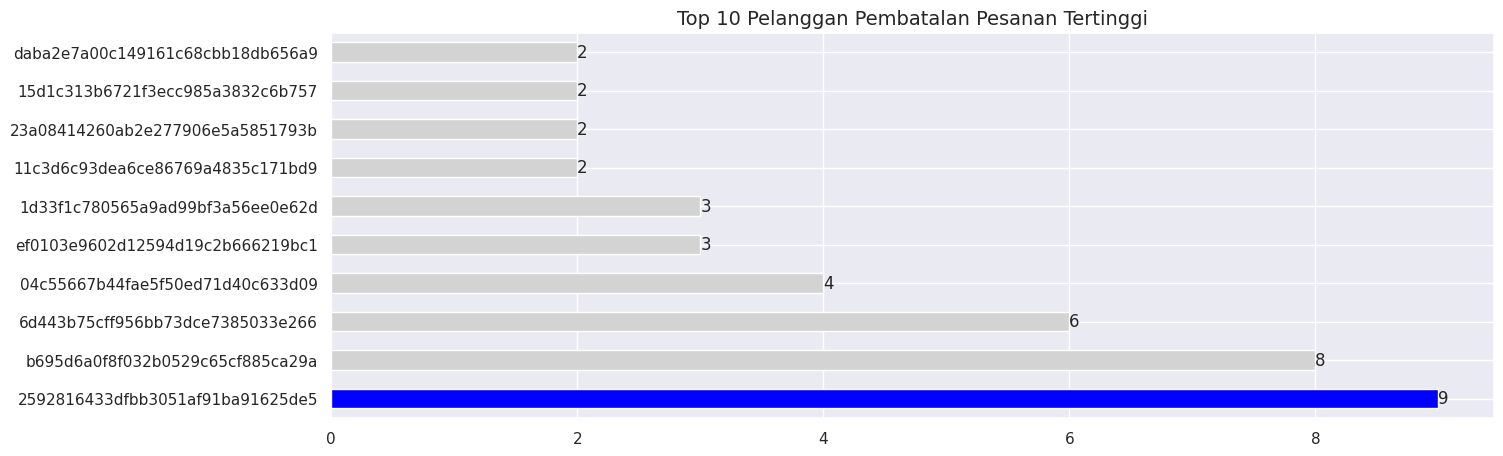

In [89]:
plot_frequency_data_kualitatif(df=canceled_grouped, feature="customer_unique_id", title="Top 10 Pelanggan Pembatalan Pesanan Tertinggi", kind="barh", top_10=True, tail=False)

**Insight:**
- Dari hasil visualisasi diatas, kita bisa nampak bahwa pelanggan 25928 paling sering membatalkan pesanan, kita bisa mengevaluasi diri penyebab pelanggan tersebut banyak melakukan pembatan pesanan, apakah akun tersebut memang akun bodong (iseng) atau memang pelanggan tersebut tidak sengaja menekan tombol checkout, atau bisa juga pengiriman barang lambat dan tidak diproses segera. Sehingga pelanggan-pelanggan tersebut mungkin memunculkan rasa kesal.

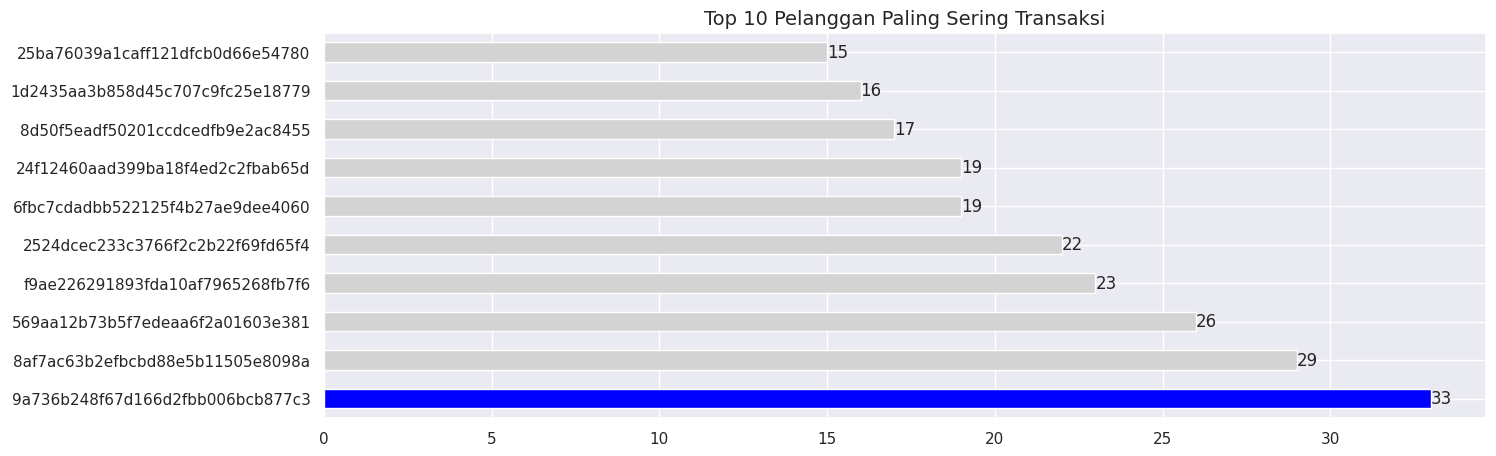

In [90]:
plot_frequency_data_kualitatif(df=customers_orders_order_payments_df, feature="customer_unique_id", title="Top 10 Pelanggan Paling Sering Transaksi", kind="barh", top_10=True, tail=False)

**Insight:**
- Pelanggan 9a73 paling sering melakukan transaksi. Sehingga pelanggan selain dari daftar top 10 pelanggan ini kita bisa melakukan rekomendasi produk lain atau memberikan promo besar-besaran agar pelanggan lain bisa melakukan pembelian yang sama seperti top 10 pelanggan ini

In [91]:
customer_unique_id_by_payment_value = customers_orders_order_payments_df.groupby("customer_unique_id").agg({
    "payment_value": "sum",
}).sort_values(by="payment_value", ascending=False)
customer_unique_id_by_payment_value

payment_value
customer_unique_id                             
0a0a92112bd4c708ca5fde585afaa872       13664.08
46450c74a0d8c5ca9395da1daac6c120        9553.02
da122df9eeddfedc1dc1f5349a1a690c        7571.63
763c8b1c9c68a0229c42c9fc6f662b93        7274.88
dc4802a71eae9be1dd28f5d788ceb526        6929.31
...                                         ...
b33336f46234b24a613ad9064d13106d          10.89
bd06ce0e06ad77a7f681f1a4960a3cc6          10.07
317cfc692e3f86c45c95697c61c853a6           9.59
4fa4365000c7090fcb8cad5713c6d3db           0.00
968fac81e2c44fb6c1e3ac2a45e6a102           0.00

[96095 rows x 1 columns]

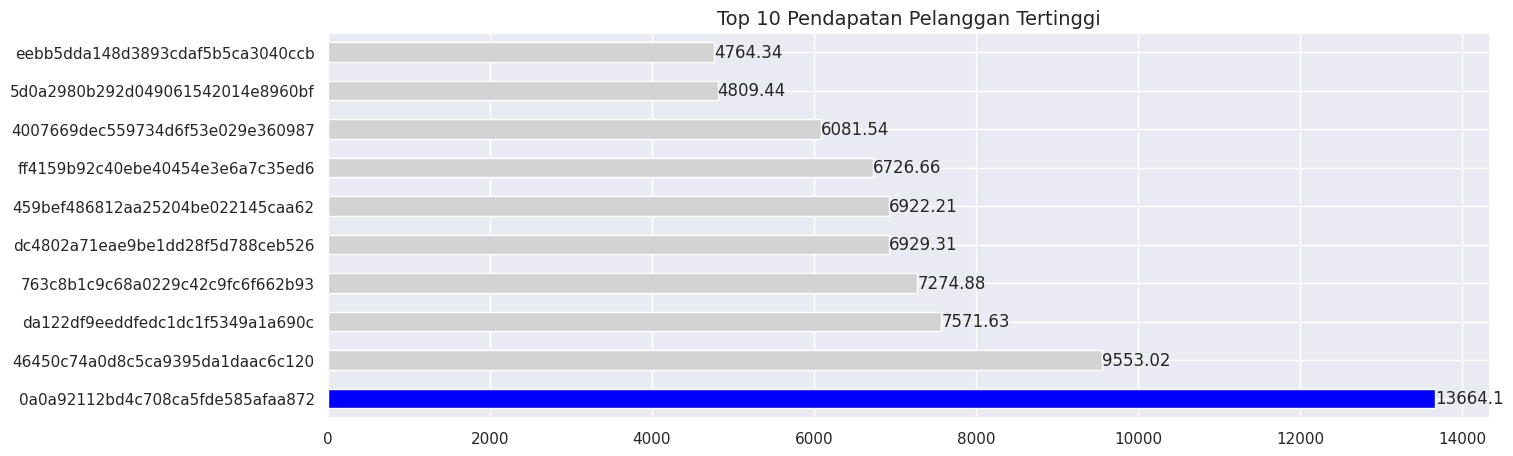

In [92]:
plot_sum_grouped_data_kuantitatif(df=customer_unique_id_by_payment_value, features="customer_unique_id", values="payment_value", title="Top 10 Pendapatan Pelanggan Tertinggi", kind="barh", top_10=True, tail=False)

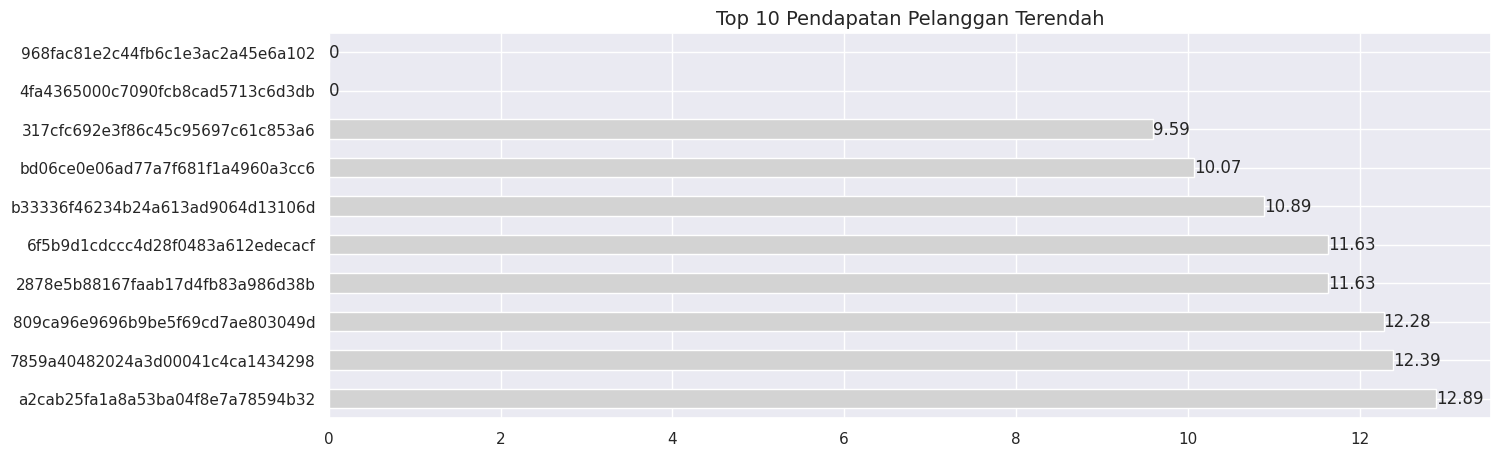

In [93]:
plot_sum_grouped_data_kuantitatif(df=customer_unique_id_by_payment_value, features="customer_unique_id", values="payment_value", title="Top 10 Pendapatan Pelanggan Terendah", kind="barh", top_10=True, tail=True)

**Insight:**
- Pada visualisasi diatas pelanggan 968f dan 4fa4 tidak memiliki pendapatan sama sekali, ini berarti pelanggan-pelanggan tersebut hanya mendaftar saja tapi tidak melakukan atau belum melakukan transaksi pembelian sama sekali.

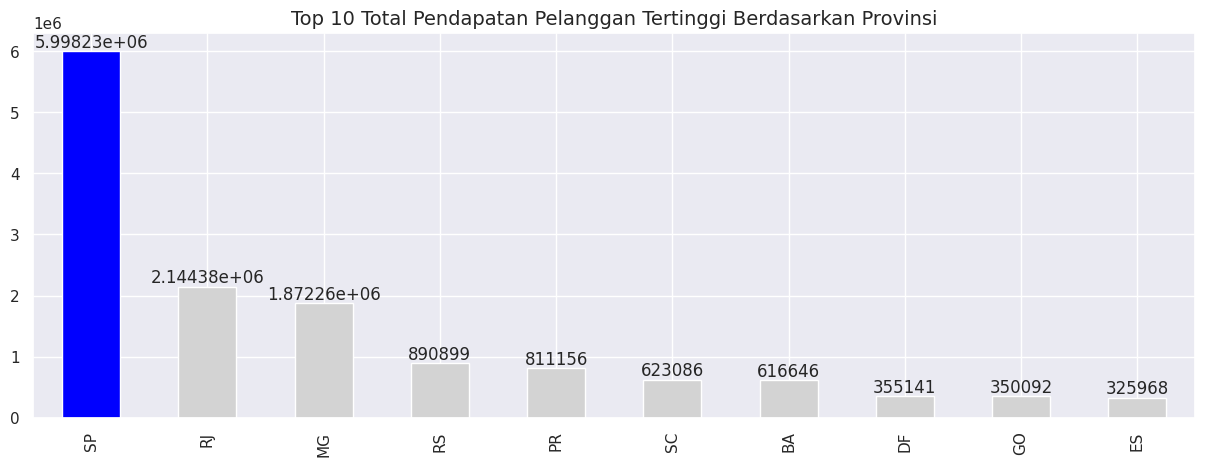

In [94]:
plot_sum_grouped_data_kuantitatif(
    df=customers_orders_order_payments_df,
    features="customer_state",
    values="payment_value",
    title="Top 10 Total Pendapatan Pelanggan Tertinggi Berdasarkan Provinsi",
    kind="bar",
    top_10=True,
    tail=False
)

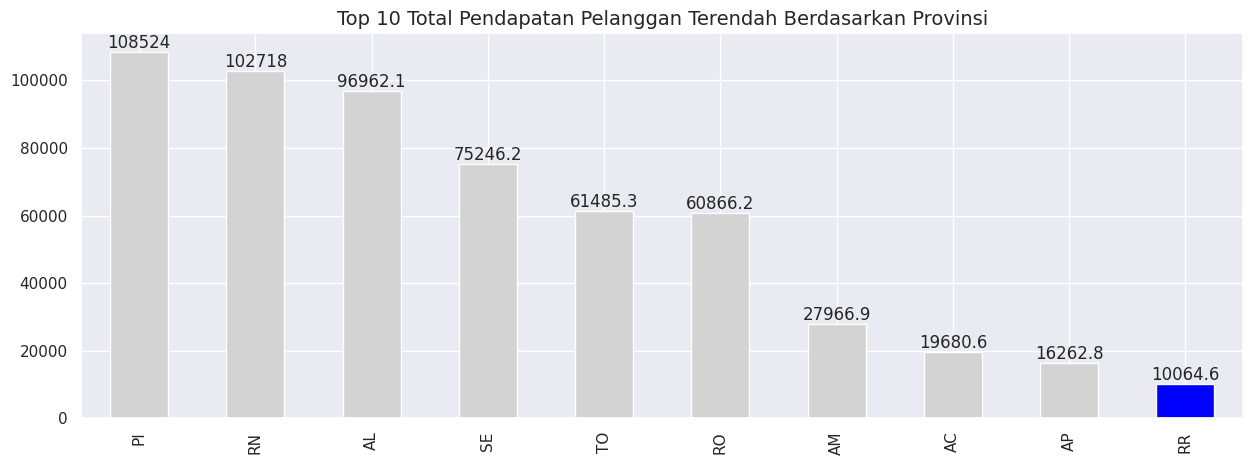

In [95]:
plot_sum_grouped_data_kuantitatif(
    df=customers_orders_order_payments_df,
    features="customer_state",
    values="payment_value",
    title="Top 10 Total Pendapatan Pelanggan Terendah Berdasarkan Provinsi",
    kind="bar",
    top_10=True,
    tail=True
)

**Insight:**
- Pendapatan tertinggi didominasi oleh wilayah SP, dan pendapatan terendah didominasi oleh wilayah RR. Ini berarti wilayah RR mungkin pelosok dan jauh dari kota ataupun UMR yang sangat minim

### Products - Order Items

In [96]:
products_df.head()

product_id product_category_name  \
0  1e9e8ef04dbcff4541ed26657ea517e5             perfumery   
1  3aa071139cb16b67ca9e5dea641aaa2f                   art   
2  96bd76ec8810374ed1b65e291975717f        sports_leisure   
3  cef67bcfe19066a932b7673e239eb23d                  baby   
4  9dc1a7de274444849c219cff195d0b71            housewares   

   product_name_lenght  product_description_lenght  product_photos_qty  \
0                 40.0                       287.0                 1.0   
1                 44.0                       276.0                 1.0   
2                 46.0                       250.0                 1.0   
3                 27.0                       261.0                 1.0   
4                 37.0                       402.0                 4.0   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  
0             225.0               16.0               10.0              14.0  
1            1000.0               30.0               18.0              20.0  
2             154.0               18.0                9.0              15.0  
3             371.0               26.0                4.0              26.0  
4             625.0               20.0               17.0              13.0

In [97]:
products_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32951 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32951 non-null  float64
 6   product_length_cm           32951 non-null  float64
 7   product_height_cm           32951 non-null  float64
 8   product_width_cm            32951 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [98]:
order_items_df.head()

order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3  7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4  ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   

   shipping_limit_date   price  freight_value  
0  2017-09-19 09:45:35   58.90          13.29  
1  2017-05-03 11:05:13  239.90          19.93  
2  2018-01-18 14:48:30  199.00          17.87  
3  2018-08-15 10:10:18   12.99          12.79  
4  2017-02-13 13:57:51  199.90          18.14

In [99]:
order_items_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [100]:
products_order_items_df = pd.merge(
    left=products_df,
    right=order_items_df,
    how="inner",
    left_on="product_id",
    right_on="product_id"
)
products_order_items_df

product_id  product_category_name  \
0       1e9e8ef04dbcff4541ed26657ea517e5              perfumery   
1       3aa071139cb16b67ca9e5dea641aaa2f                    art   
2       96bd76ec8810374ed1b65e291975717f         sports_leisure   
3       cef67bcfe19066a932b7673e239eb23d                   baby   
4       9dc1a7de274444849c219cff195d0b71             housewares   
...                                  ...                    ...   
112645  83808703fc0706a22e264b9d75f04a2e  computers_accessories   
112646  83808703fc0706a22e264b9d75f04a2e  computers_accessories   
112647  83808703fc0706a22e264b9d75f04a2e  computers_accessories   
112648  83808703fc0706a22e264b9d75f04a2e  computers_accessories   
112649  106392145fca363410d287a815be6de4         bed_bath_table   

        product_name_lenght  product_description_lenght  product_photos_qty  \
0                      40.0                       287.0                 1.0   
1                      44.0                       276.0                 1.0   
2                      46.0                       250.0                 1.0   
3                      27.0                       261.0                 1.0   
4                      37.0                       402.0                 4.0   
...                     ...                         ...                 ...   
112645                 60.0                       156.0                 2.0   
112646                 60.0                       156.0                 2.0   
112647                 60.0                       156.0                 2.0   
112648                 60.0                       156.0                 2.0   
112649                 58.0                       309.0                 1.0   

        product_weight_g  product_length_cm  product_height_cm  \
0                  225.0               16.0               10.0   
1                 1000.0               30.0               18.0   
2                  154.0               18.0                9.0   
3                  371.0               26.0                4.0   
4                  625.0               20.0               17.0   
...                  ...                ...                ...   
112645             700.0               31.0               13.0   
112646             700.0               31.0               13.0   
112647             700.0               31.0               13.0   
112648             700.0               31.0               13.0   
112649            2083.0               12.0                2.0   

        product_width_cm                          order_id  order_item_id  \
0                   14.0  e17e4f88e31525f7deef66779844ddce              1   
1                   20.0  5236307716393b7114b53ee991f36956              1   
2                   15.0  01f66e58769f84129811d43eefd187fb              1   
3                   26.0  143d00a4f2dde4e0364ee1821577adb3              1   
4                   13.0  86cafb8794cb99a9b1b77fc8e48fbbbb              1   
...                  ...                               ...            ...   
112645              20.0  59e88b7d3675e89aceaf86f372d3bc9a              2   
112646              20.0  6e4465d771f02e4fe335225de3c6c043              1   
112647              20.0  6e4465d771f02e4fe335225de3c6c043              2   
112648              20.0  6e4465d771f02e4fe335225de3c6c043              3   
112649               7.0  f3a47ba087f05d39a74ed1b653f0be1b              1   

                               seller_id  shipping_limit_date   price  \
0       5670f4db5b62c43d542e1b2d56b0cf7c  2018-04-30 17:33:54   10.91   
1       b561927807645834b59ef0d16ba55a24  2018-02-06 19:11:15  248.00   
2       7b07b3c7487f0ea825fc6df75abd658b  2018-07-11 21:30:20   79.80   
3       c510bc1718f0f2961eaa42a23330681a  2018-08-07 09:10:13  112.30   
4       0be8ff43f22e456b4e0371b2245e4d01  2018-04-17 01:30:23   37.90   
...                                  ...                  ...     ...   
112645  4324dd16853115efb0fd9d0d131ba6f4  2018-

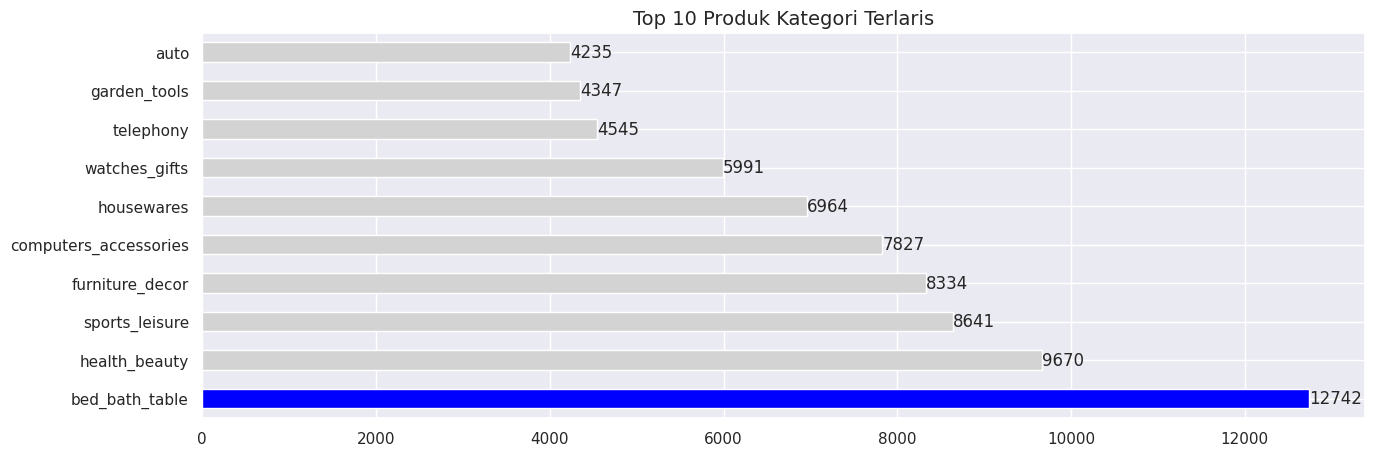

In [101]:
plot_frequency_data_kualitatif(df=products_order_items_df, feature="product_category_name", title="Top 10 Produk Kategori Terlaris", kind="barh", top_10=True, tail=False)

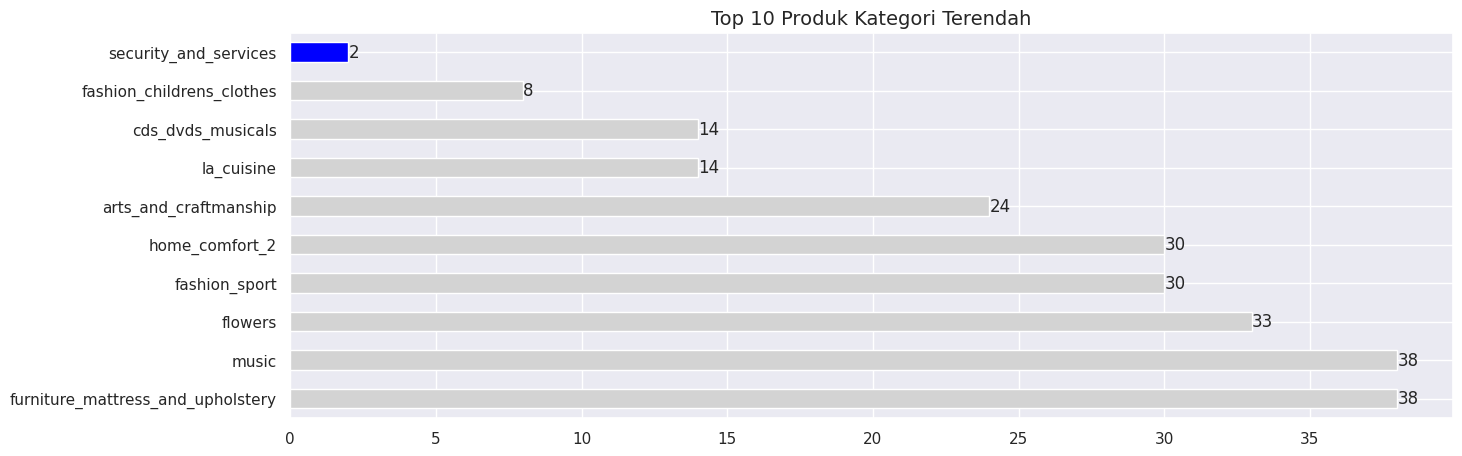

In [102]:
plot_frequency_data_kualitatif(df=products_order_items_df, feature="product_category_name", title="Top 10 Produk Kategori Terendah", kind="barh", top_10=True, tail=True)

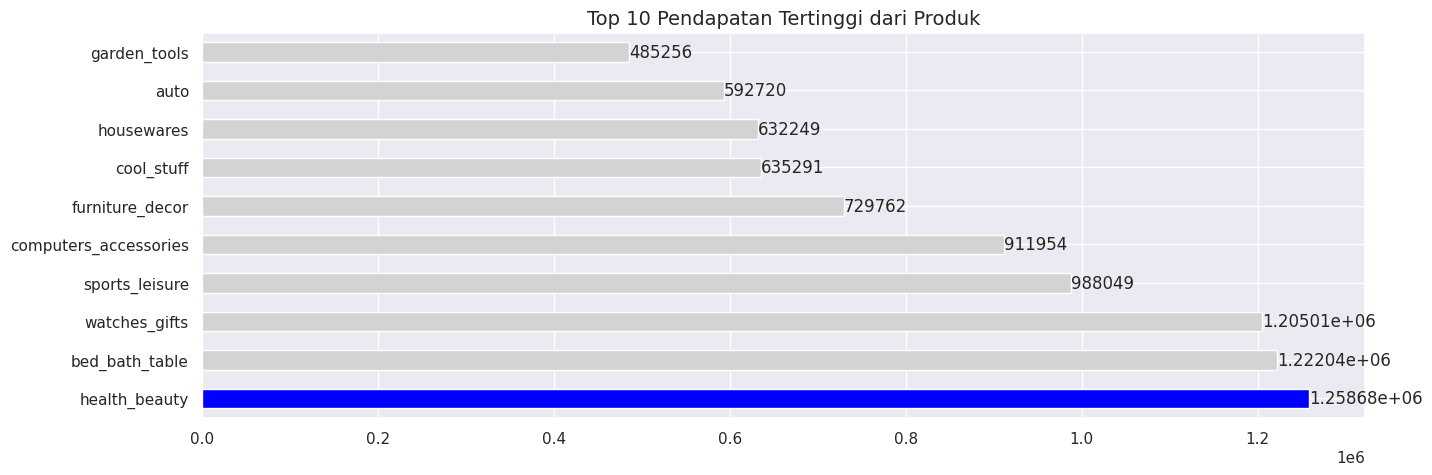

In [103]:
plot_sum_grouped_data_kuantitatif(
    df=products_order_items_df,
    features="product_category_name",
    values="price",
    title="Top 10 Pendapatan Tertinggi dari Produk",
    kind="barh",
    top_10=True,
    tail=False
)

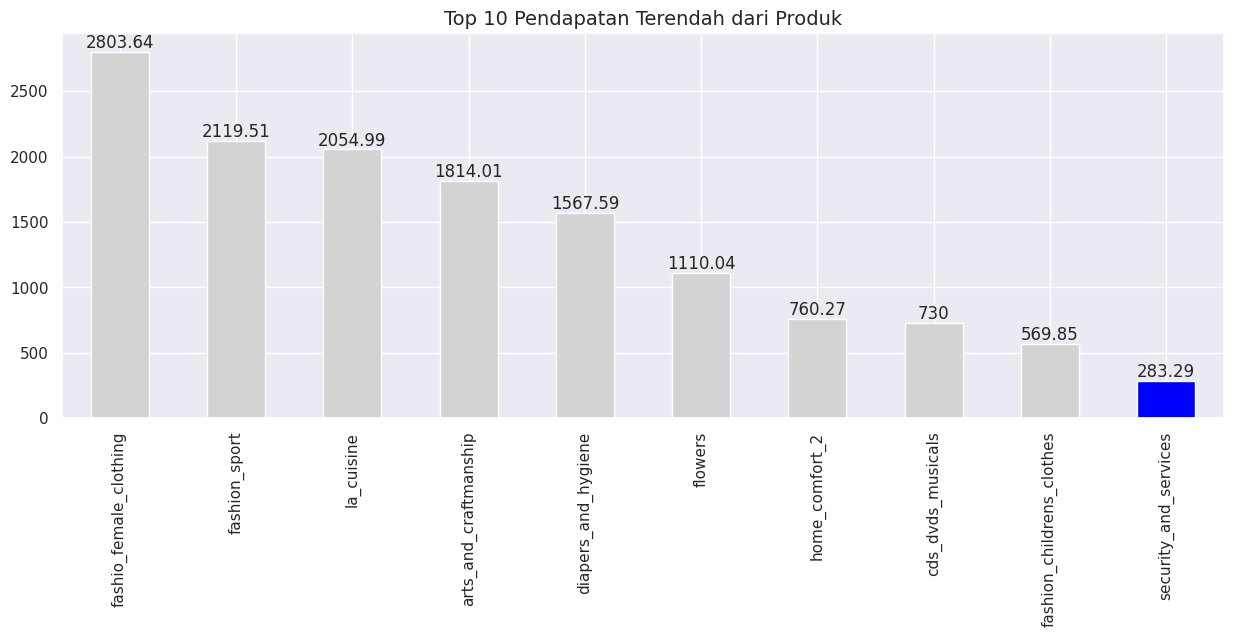

In [104]:
plot_sum_grouped_data_kuantitatif(
    df=products_order_items_df,
    features="product_category_name",
    values="price",
    title="Top 10 Pendapatan Terendah dari Produk",
    kind="bar",
    top_10=True,
    tail=True
)

**Insight:**
- Kategori produk terlaris ada di kategori produk tempat tidur, sedangkan kategori produk keamanan dan layanan berada di produk terendah, ini berarti segmentasi pelanggan kita dominan belanja kategori peralatan tempat tidur dibandingkan mementingkan peralatan keamanan. Karena itu produk kategori peralatan keamanan kita bisa lakukan promosi besar-besaran agar produk ini banyak terjual, misalnya dengan menambahkan inovasi pada produk keamanan ini berbasis teknologi yang canggih ataupun melakukan diskon.
- Kateogori produk tempat tidur selain kategori populer juga merupakan kategori paling menguntungkan bagi perusahaan tapi di urutan ke dua setelah kategori produk kesehatan kecantikan

### Products Order Items - Orders

In [105]:
products_order_items_orders_df = pd.merge(
    left=products_order_items_df,
    right=orders_df,
    how="inner",
    left_on="order_id",
    right_on="order_id"
)
products_order_items_orders_df.head()

product_id product_category_name  \
0  1e9e8ef04dbcff4541ed26657ea517e5             perfumery   
1  3aa071139cb16b67ca9e5dea641aaa2f                   art   
2  96bd76ec8810374ed1b65e291975717f        sports_leisure   
3  cef67bcfe19066a932b7673e239eb23d                  baby   
4  9dc1a7de274444849c219cff195d0b71            housewares   

   product_name_lenght  product_description_lenght  product_photos_qty  \
0                 40.0                       287.0                 1.0   
1                 44.0                       276.0                 1.0   
2                 46.0                       250.0                 1.0   
3                 27.0                       261.0                 1.0   
4                 37.0                       402.0                 4.0   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  \
0             225.0               16.0               10.0              14.0   
1            1000.0               30.0               18.0              20.0   
2             154.0               18.0                9.0              15.0   
3             371.0               26.0                4.0              26.0   
4             625.0               20.0               17.0              13.0   

                           order_id  ...  shipping_limit_date   price  \
0  e17e4f88e31525f7deef66779844ddce  ...  2018-04-30 17:33:54   10.91   
1  5236307716393b7114b53ee991f36956  ...  2018-02-06 19:11:15  248.00   
2  01f66e58769f84129811d43eefd187fb  ...  2018-07-11 21:30:20   79.80   
3  143d00a4f2dde4e0364ee1821577adb3  ...  2018-08-07 09:10:13  112.30   
4  86cafb8794cb99a9b1b77fc8e48fbbbb  ...  2018-04-17 01:30:23   37.90   

  freight_value                       customer_id  order_status  \
0          7.39  f8a3e963a310aa58b60a5b1fed5bceb5     delivered   
1         17.99  03fc97548af8f58fefc768d12b546c9c     delivered   
2          7.82  e41819d1c95c12c9ce495b630eab8aee     delivered   
3          9.54  322162b5ca010c2b059cb5224dd818b1     delivered   
4          8.29  c11c31965ff02cc1d7132df8edfcbc22     delivered   

  order_purchase_timestamp    order_approved_at order_delivered_carrier_date  \
0      2018-04-24 16:16:53  2018-04-24 19:04:19          2018-04-25 17:01:00   
1      2018-01-31 18:55:36  2018-01-31 19:11:15          2018-02-05 22:44:47   
2      2018-07-09 21:18:01  2018-07-09 21:30:20          2018-07-10 11:49:00   
3      2018-08-03 08:55:50  2018-08-03 09:31:42          2018-08-03 11:48:00   
4      2018-04-11 01:06:37  2018-04-11 01:30:23          2018-04-12 22:56:27   

  order_delivered_customer_date order_estimated_delivery_date  
0           2018-04-27 16:42:17           2018-05-09 00:00:00  
1           2018-02-16 13:27:08           2018-02-22 00:00:00  
2           2018-07-11 23:24:16           2018-07-18 00:00:00  
3           2018-08-06 15:14:32           2018-08-08 00:00:00  
4           2018-04-13 22:41:44           2018-04-26 00:00:00  

[5 rows x 22 columns]

In [106]:
products_order_items_orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 22 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   product_id                     112650 non-null  object        
 1   product_category_name          112650 non-null  object        
 2   product_name_lenght            111047 non-null  float64       
 3   product_description_lenght     111047 non-null  float64       
 4   product_photos_qty             111047 non-null  float64       
 5   product_weight_g               112650 non-null  float64       
 6   product_length_cm              112650 non-null  float64       
 7   product_height_cm              112650 non-null  float64       
 8   product_width_cm               112650 non-null  float64       
 9   order_id                       112650 non-null  object        
 10  order_item_id                  112650 non-null  int64         
 11  

**Insight:**
- Melakukan konversi tipe data dari object ke datetime pada atribut order_purchase_timestamp tujuannya agar kita bisa melakukan pemanggilan hari, bulan dan tahun dengan fleksibel pada RFM Analisis

In [107]:
rfm_df = rfm_df(df=products_order_items_orders_df, customer_id="customer_id", order_date="order_purchase_timestamp", order_id="order_id", total_price="price")
rfm_df.head()

customer_id  frequency  monetary  recency
0  00012a2ce6f8dcda20d059ce98491703          1     89.80      337
1  000161a058600d5901f007fab4c27140          1     54.90      458
2  0001fd6190edaaf884bcaf3d49edf079          1    179.99      596
3  0002414f95344307404f0ace7a26f1d5          1    149.90      427
4  000379cdec625522490c315e70c7a9fb          1     93.00      198

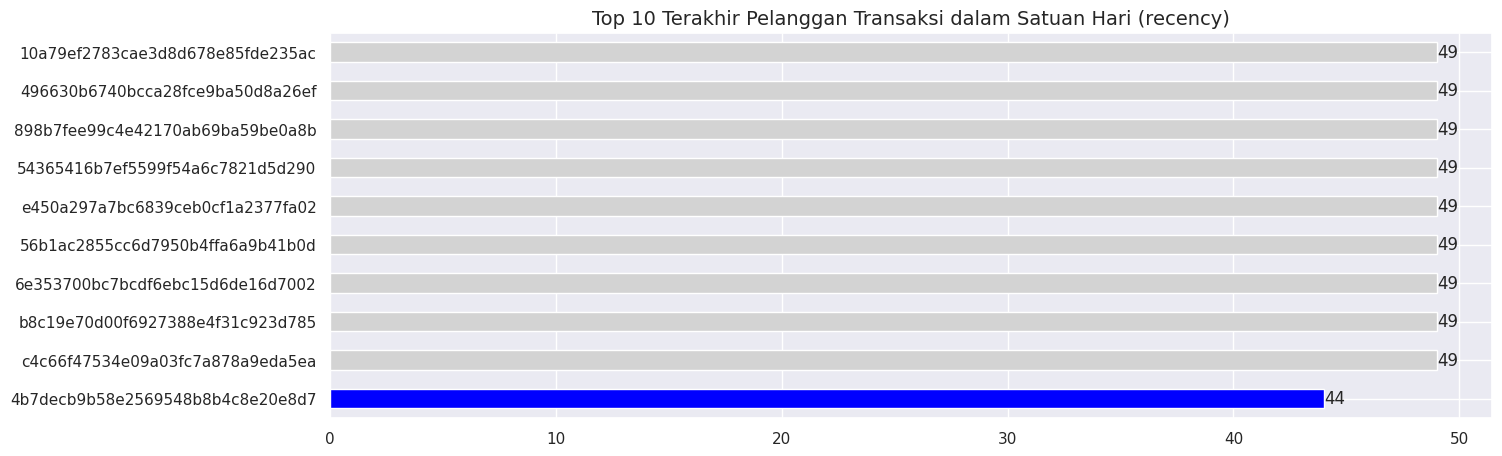

In [108]:
plot_rfm_score(rfm_df=rfm_df, feature="recency", title="Top 10 Terakhir Pelanggan Transaksi dalam Satuan Hari (recency)", kind="barh", top_10_highest=True)

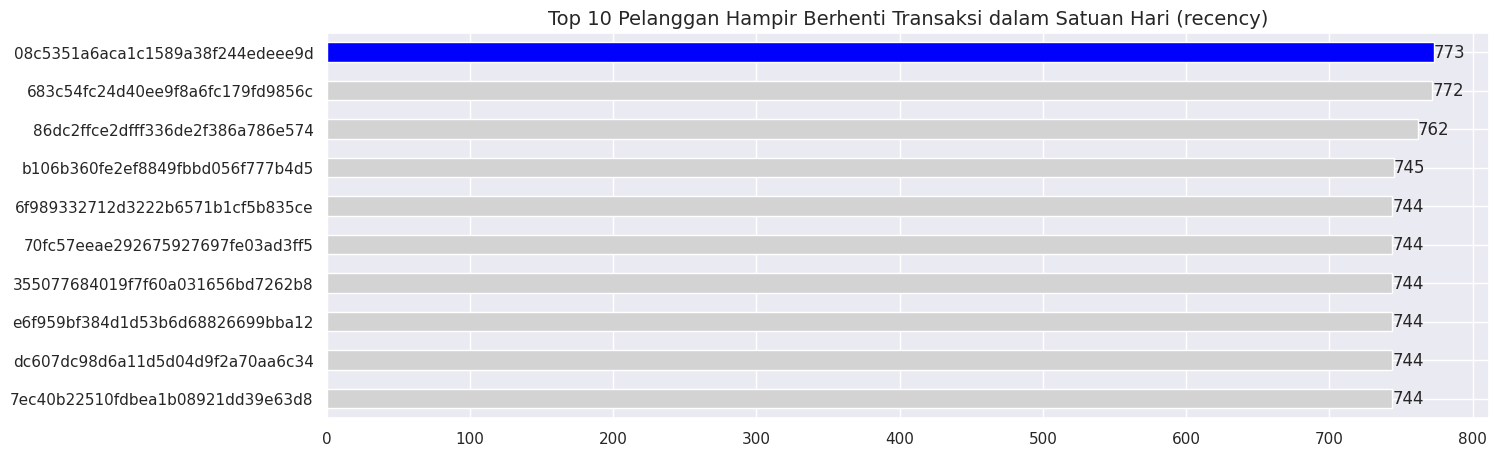

In [109]:
plot_rfm_score(rfm_df=rfm_df, feature="recency", title="Top 10 Pelanggan Hampir Berhenti Transaksi dalam Satuan Hari (recency)", kind="barh", top_10_highest=False)

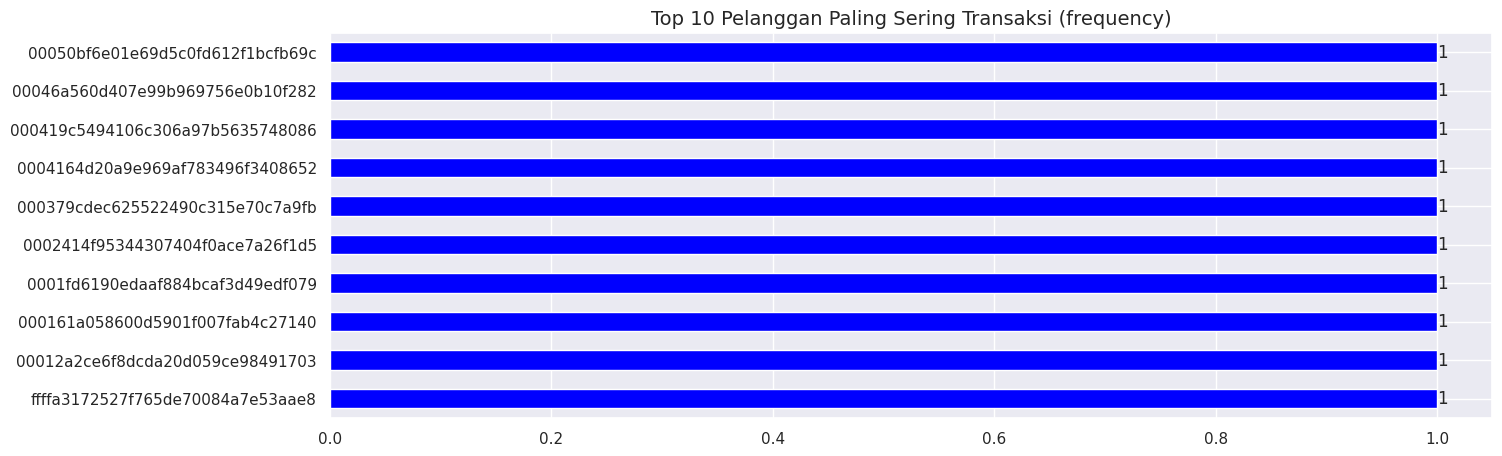

In [120]:
plot_rfm_score(rfm_df=rfm_df, feature="frequency", title="Top 10 Pelanggan Paling Sering Transaksi (frequency)", kind="barh", top_10_highest=True)

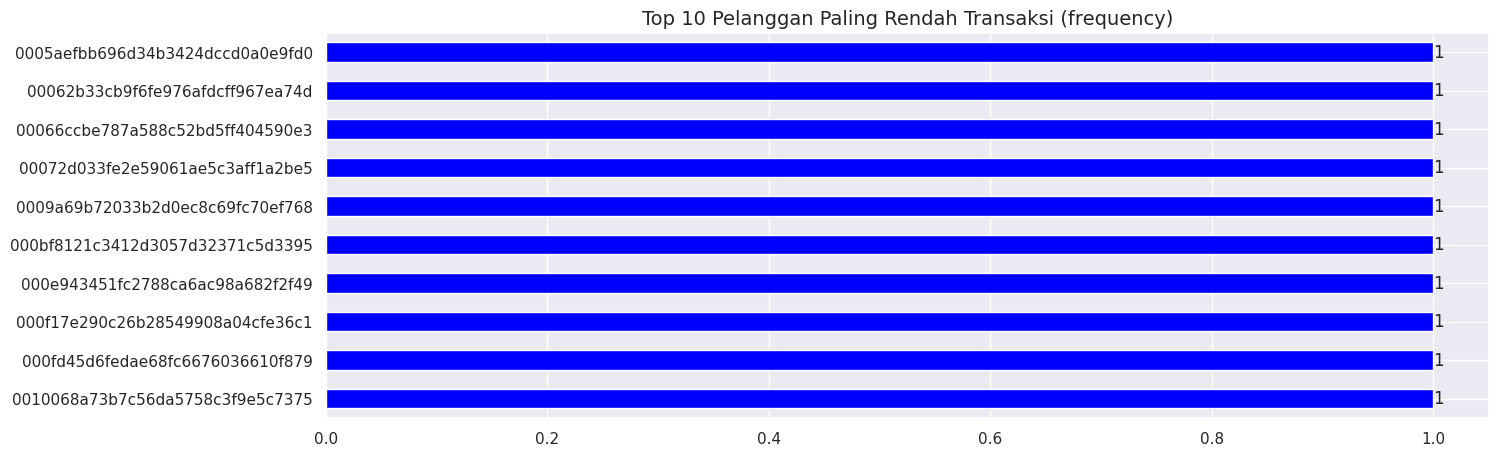

In [121]:
plot_rfm_score(rfm_df=rfm_df, feature="frequency", title="Top 10 Pelanggan Paling Rendah Transaksi (frequency)", kind="barh", top_10_highest=False)

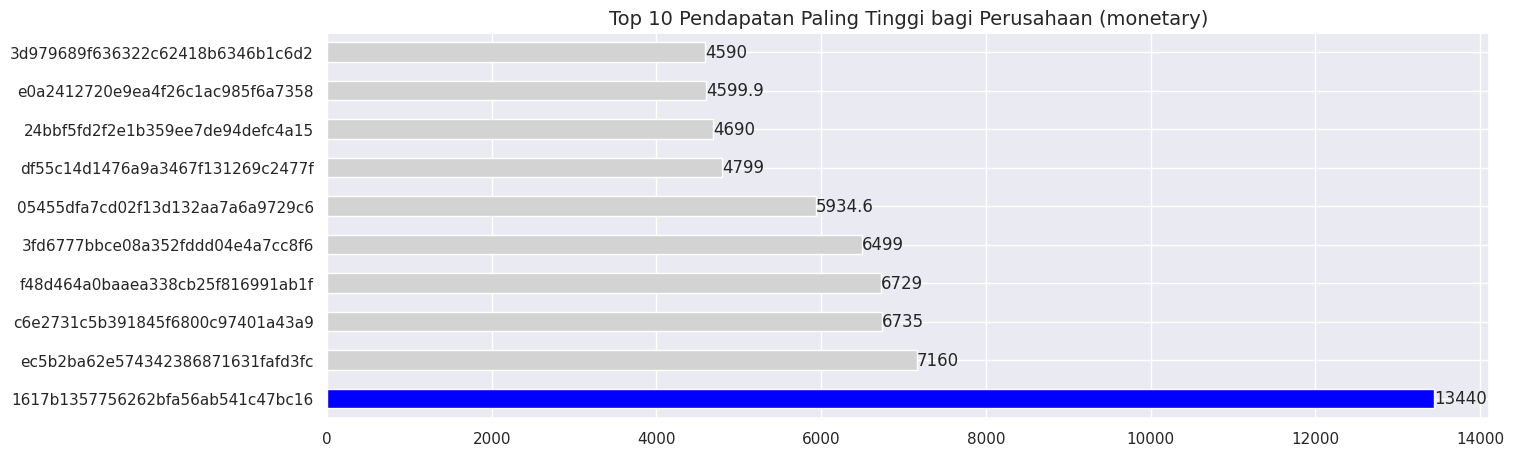

In [122]:
plot_rfm_score(rfm_df=rfm_df, feature="monetary", title="Top 10 Pendapatan Paling Tinggi bagi Perusahaan (monetary)", kind="barh", top_10_highest=True)

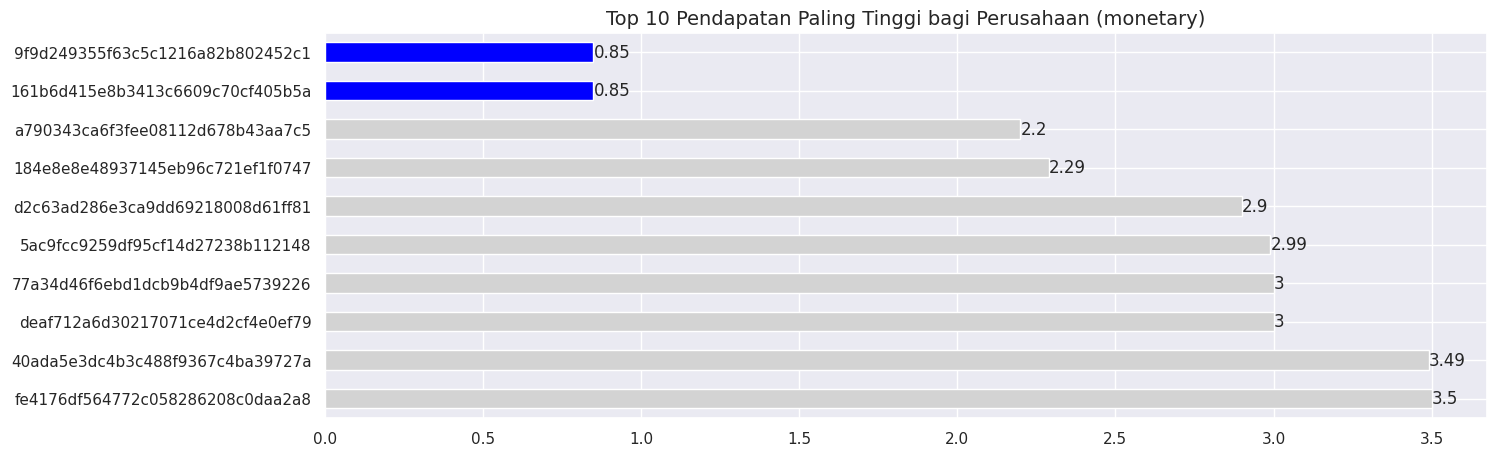

In [123]:
plot_rfm_score(rfm_df=rfm_df, feature="monetary", title="Top 10 Pendapatan Paling Tinggi bagi Perusahaan (monetary)", kind="barh", top_10_highest=False)

**Insight:**
- Pelanggan 4a7d paling sering melakukan transaksi (langganan), sedangkan pelanggan 08c5 justru jarang melakukan transaksi ini berarti pelanggan 08c5 akan mengalami pemberhentian langganan (churn) solusi dari perspektif perusahaan bisa melakukan promosi besar-besaran pada pelanggan tersebut tujuannya untuk menghindari berhentinya langganan dan kembali menjadi aktif transaksi.
- Pelanggan 1617 termasuk pelanggan yang paling menguntungkan bagi perusahaan, sedangkan pelanggan 9f9d dan 161d pelanggan yang pendapatannya paling rendah bagi perusahaan, ini mungkin disebabkan karena pelanggan 9f9d dan pelanggan 161d memiliki pendapatan UMR atau bahkan dibawah UMR yang hanya cukup unuk memenuhi kebutuhan pokok saja dibandingkan membeli barang baru.

## Visualization & Explanatory Analysis

### Pertanyaan 1: Produk apa yang paling banyak dan sedikit terjual ?

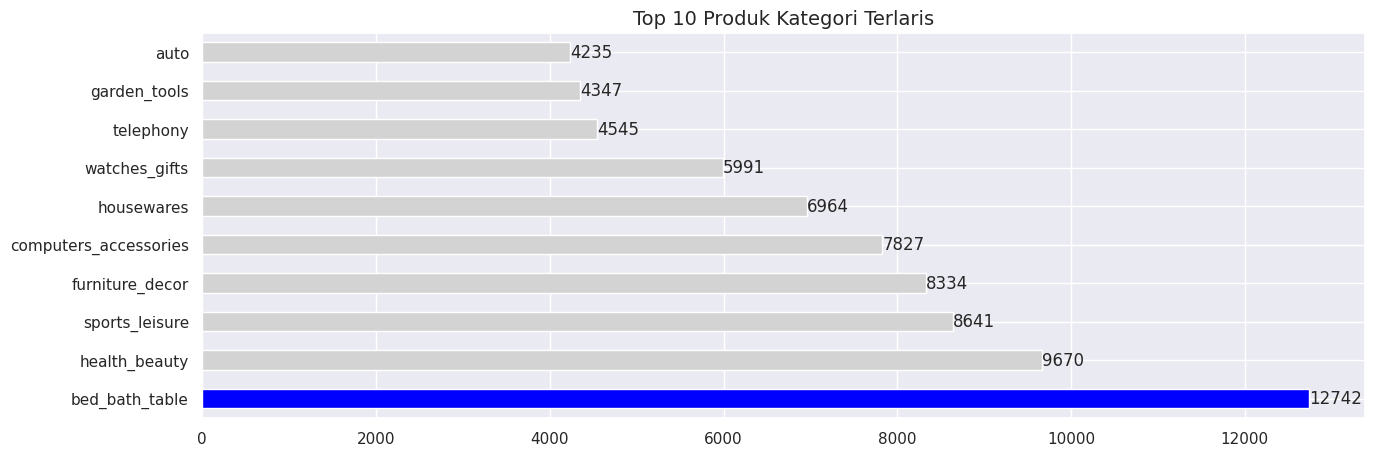

In [110]:
plot_frequency_data_kualitatif(df=products_order_items_df, feature="product_category_name", title="Top 10 Produk Kategori Terlaris", kind="barh", top_10=True, tail=False)

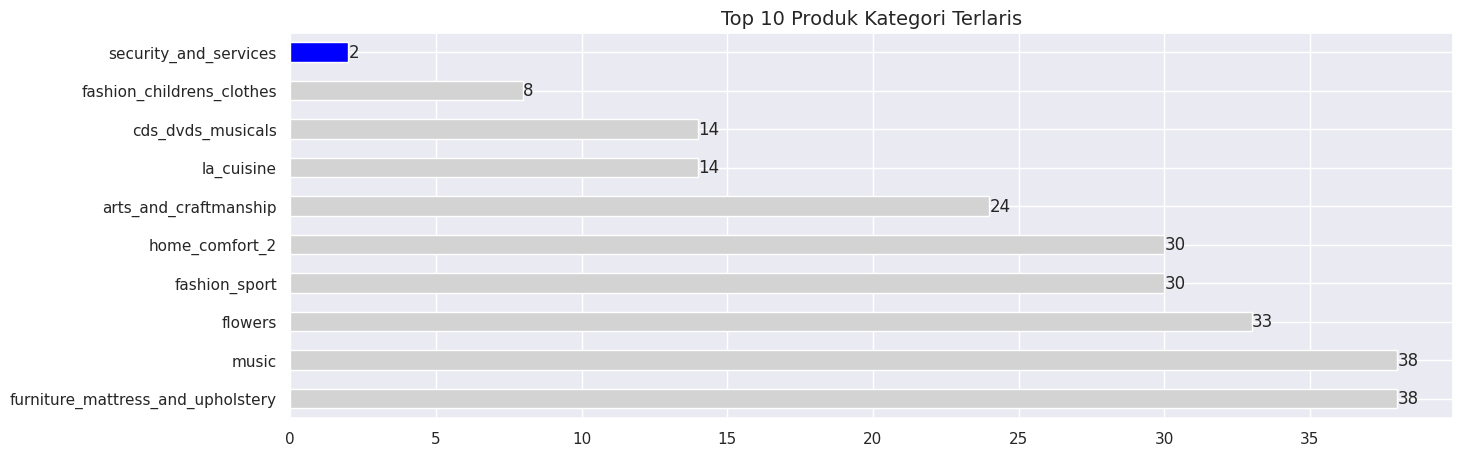

In [111]:
plot_frequency_data_kualitatif(df=products_order_items_df, feature="product_category_name", title="Top 10 Produk Kategori Terlaris", kind="barh", top_10=True, tail=True)

**Insight:**
- Kategori produk terlaris ada di kategori produk tempat tidur, sedangkan kategori produk keamanan dan layanan berada di produk terendah, ini berarti segmentasi pelanggan kita dominan belanja kategori peralatan tempat tidur dibandingkan mementingkan peralatan keamanan. Karena itu produk kategori peralatan keamanan kita bisa lakukan promosi besar-besaran agar produk ini banyak terjual, misalnya dengan menambahkan inovasi pada produk keamanan ini berbasis teknologi yang canggih ataupun melakukan diskon.

### Pertanyaan 2: Wilayah mana yang paling menguntungkan perusahaan dan paling sering melakukan transaksi ?

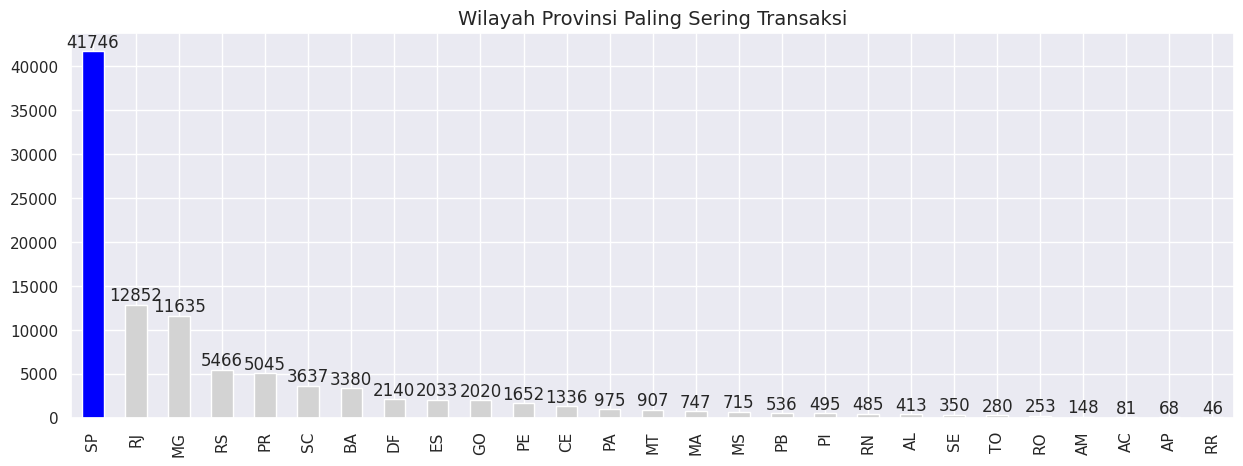

In [112]:
plot_frequency_data_kualitatif(df=customers_df, feature="customer_state", title="Wilayah Provinsi Paling Sering Transaksi", kind="bar", top_10=False, tail=False)

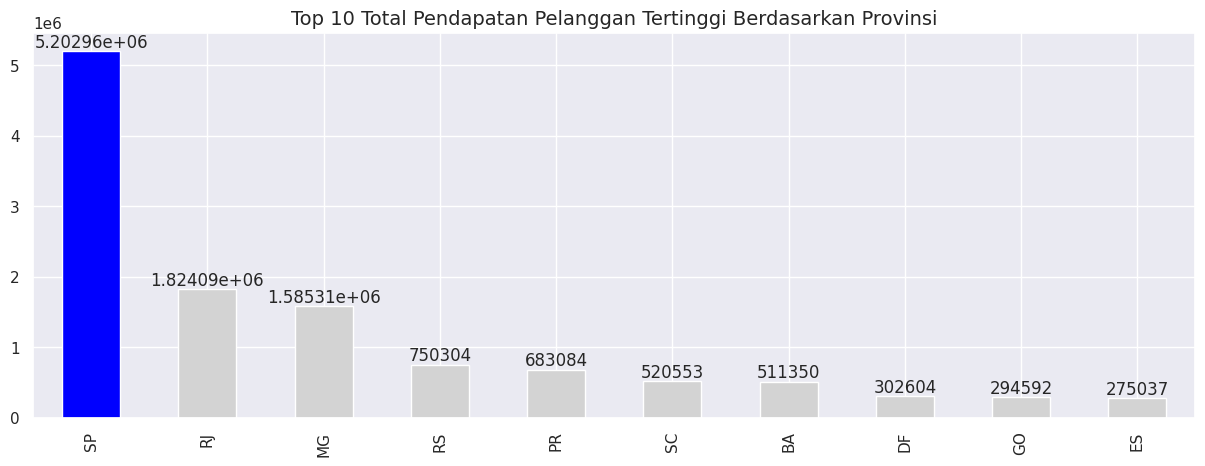

In [113]:
plot_sum_grouped_data_kuantitatif(
    df=customers_orders_order_items_df,
    features="customer_state",
    values="price",
    title="Top 10 Total Pendapatan Pelanggan Tertinggi Berdasarkan Provinsi",
    kind="bar",
    top_10=True,
    tail=False
)

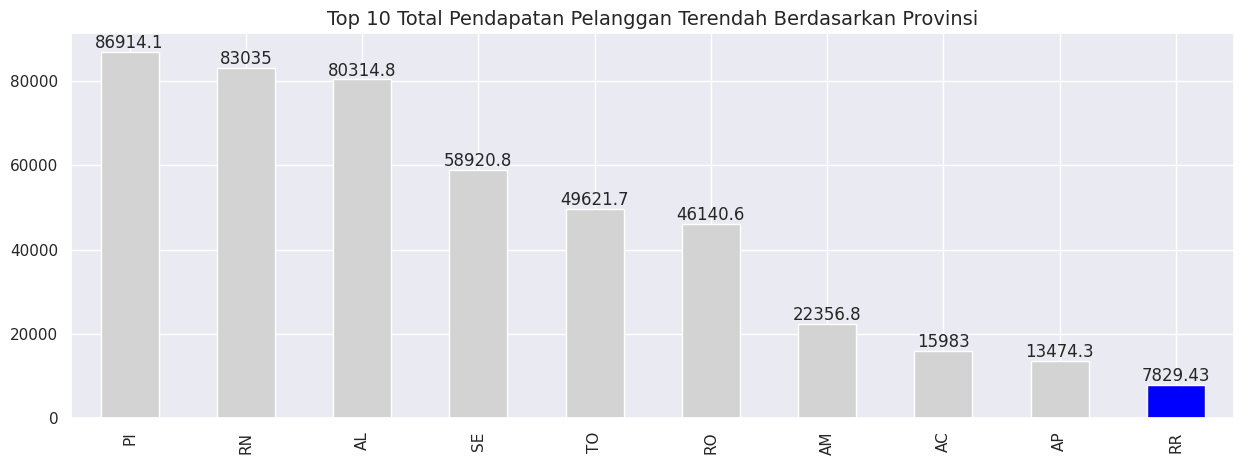

In [114]:
plot_sum_grouped_data_kuantitatif(
    df=customers_orders_order_items_df,
    features="customer_state",
    values="price",
    title="Top 10 Total Pendapatan Pelanggan Terendah Berdasarkan Provinsi",
    kind="bar",
    top_10=True,
    tail=True
)

**Insight:**
- Pelanggan didominasi oleh wilayah SP  yang melonjak tinggi dibandingkan wilayah lainnya, hampir 4 kali lipat dari wilayah RJ. Selain mendominasi Wilayah SP juga menunjukan pendapatan yang paling menguntungkan bagi perusahaan
- Pendapatan terendah didominasi oleh wilayah RR. Ini berarti wilayah RR mungkin pelosok dan jauh dari kota ataupun UMR yang sangat minim sehingga lebih mementingkan kebutuhan pokok dibandingkan belanja

### Pertanyaan 3: Kapan terakhir pelanggan melakukan transaksi ? (Recency)

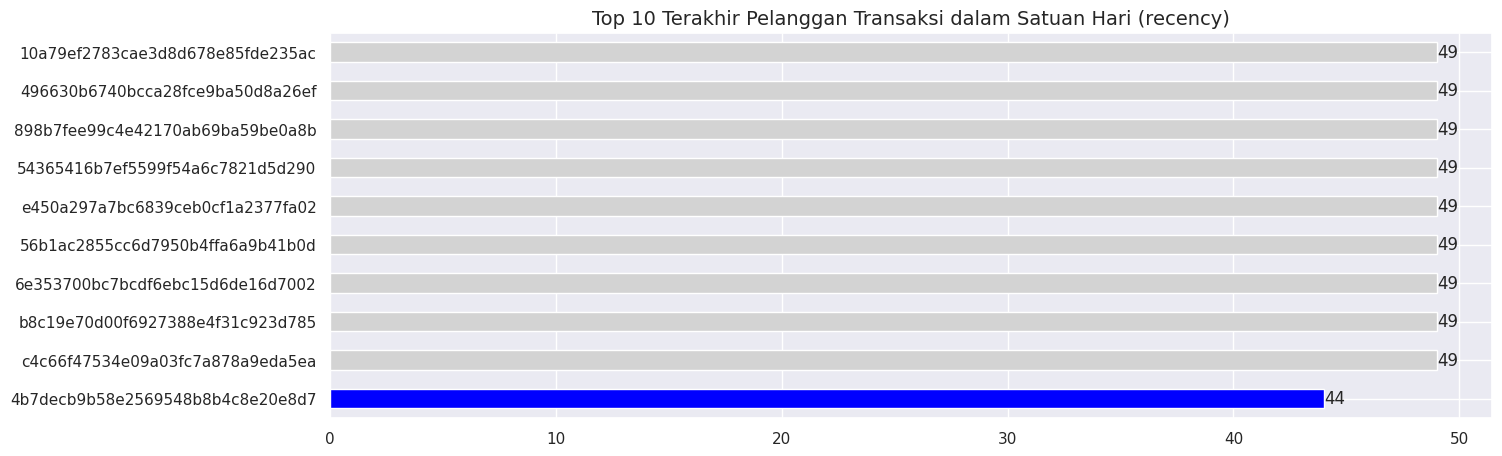

In [124]:
plot_rfm_score(rfm_df=rfm_df, feature="recency", title="Top 10 Terakhir Pelanggan Transaksi dalam Satuan Hari (recency)", kind="barh", top_10_highest=True)

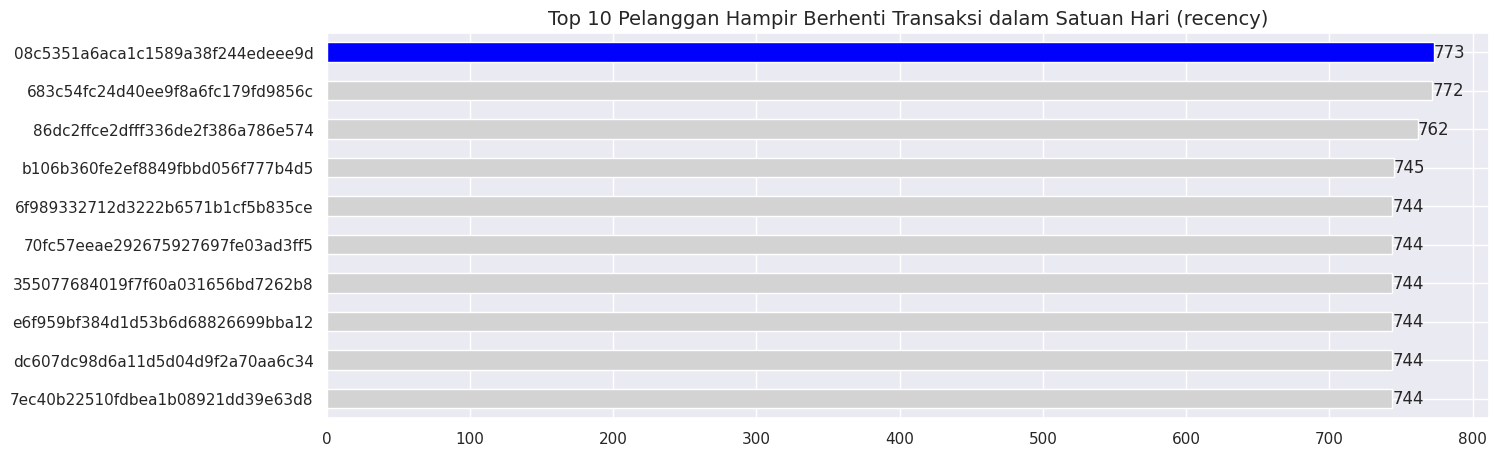

In [125]:
plot_rfm_score(rfm_df=rfm_df, feature="recency", title="Top 10 Pelanggan Hampir Berhenti Transaksi dalam Satuan Hari (recency)", kind="barh", top_10_highest=False)

**Insight:**
- Pelanggan 4a7d paling sering melakukan transaksi (langganan), sedangkan pelanggan 08c5 justru jarang melakukan transaksi ini berarti pelanggan 08c5 akan mengalami pemberhentian langganan (churn) solusi dari perspektif perusahaan bisa melakukan promosi besar-besaran pada pelanggan tersebut tujuannya untuk menghindari berhentinya langganan dan kembali menjadi aktif transaksi.

### Pertanyaan 4 : Seberapa sering seorang pelanggan melakukan transaksi ? (Frequency)

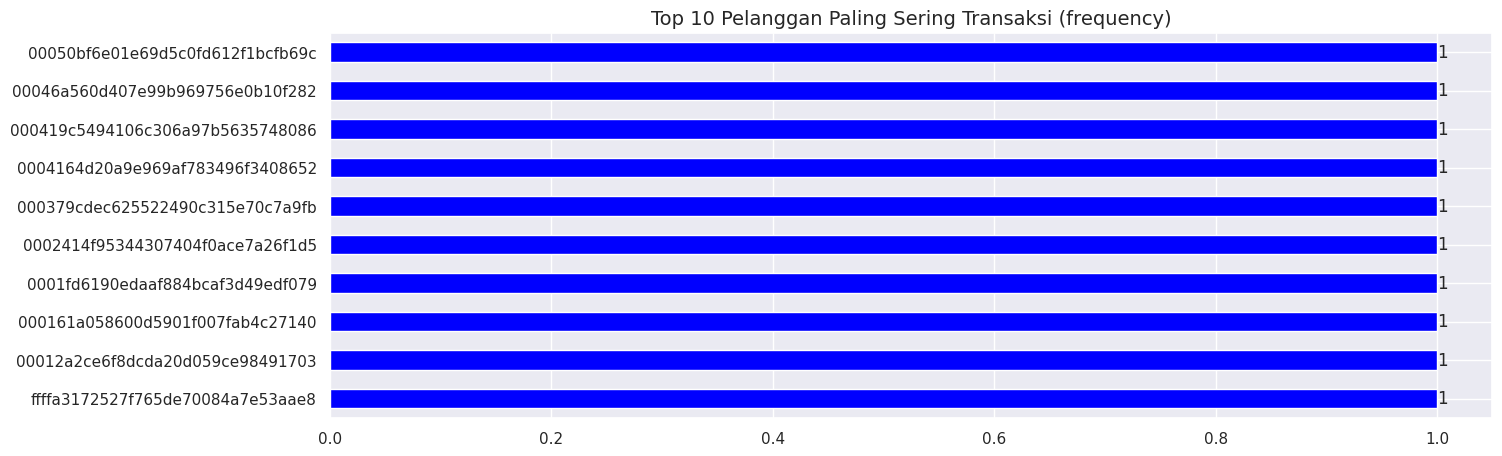

In [126]:
plot_rfm_score(rfm_df=rfm_df, feature="frequency", title="Top 10 Pelanggan Paling Sering Transaksi (frequency)", kind="barh", top_10_highest=True)

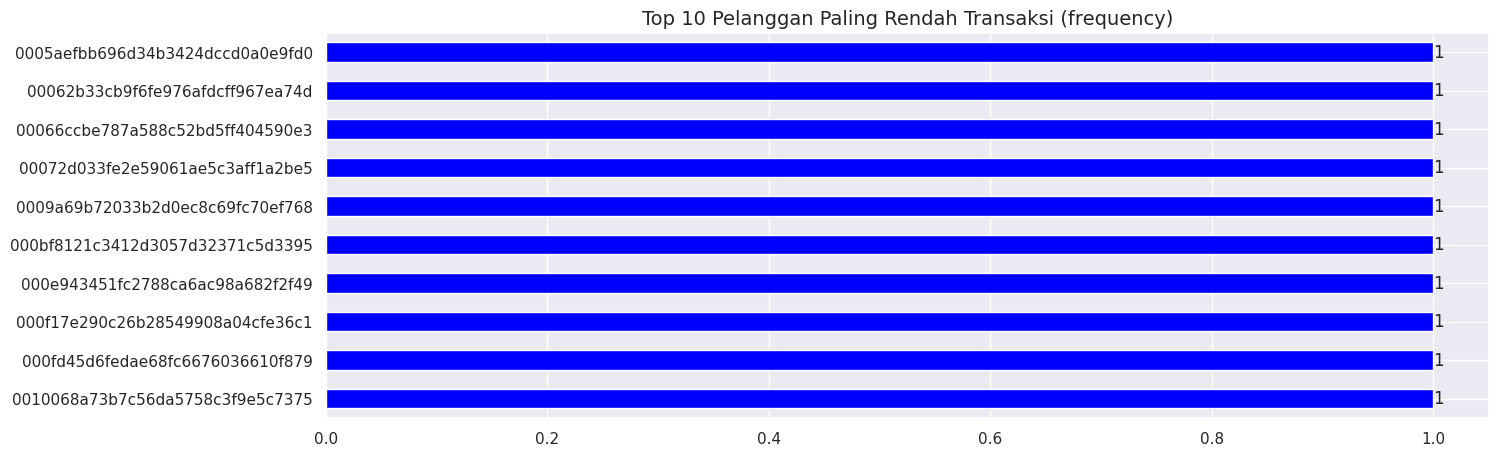

In [127]:
plot_rfm_score(rfm_df=rfm_df, feature="frequency", title="Top 10 Pelanggan Paling Rendah Transaksi (frequency)", kind="barh", top_10_highest=False)

**Insight:**
- Pada Hasil visualisasi diatas, seditdaknya pelanggan memilki transaksi 1 kali baik pelanggan langganan baik pelanggan yang sering transaksi ataupun yang jarang transaksi

### Pertanyaan 5: Berapa banyak uang yang dihabiskan pelanggan dalam beberapa bulan terakhir ? (Monetary)

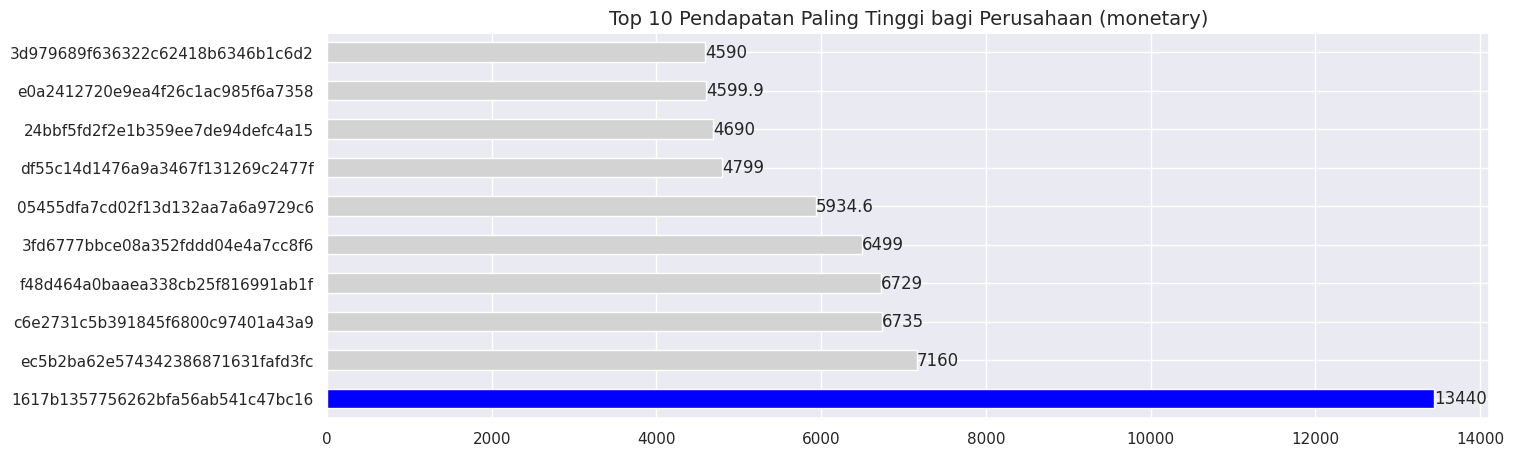

In [128]:
plot_rfm_score(rfm_df=rfm_df, feature="monetary", title="Top 10 Pendapatan Paling Tinggi bagi Perusahaan (monetary)", kind="barh", top_10_highest=True)

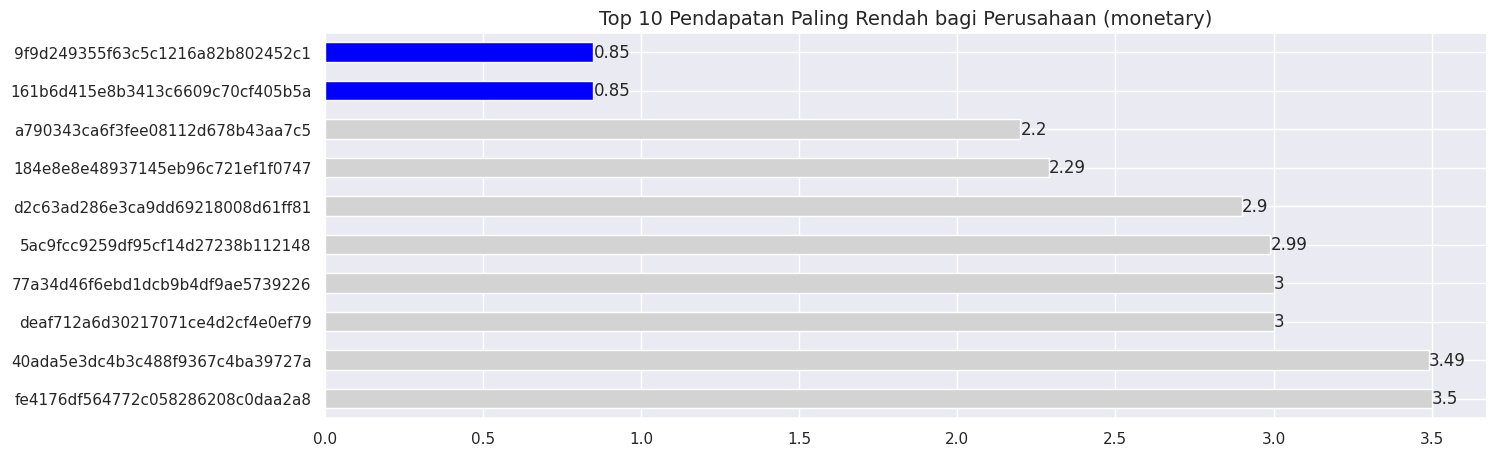

In [129]:
plot_rfm_score(rfm_df=rfm_df, feature="monetary", title="Top 10 Pendapatan Paling Rendah bagi Perusahaan (monetary)", kind="barh", top_10_highest=False)

**Insight:**
- Pelanggan 1617 termasuk pelanggan yang paling menguntungkan bagi perusahaan, sedangkan pelanggan 9f9d dan 161d pelanggan yang pendapatannya paling rendah bagi perusahaan, ini mungkin disebabkan karena pelanggan 9f9d dan pelanggan 161d memiliki pendapatan UMR atau bahkan dibawah UMR yang hanya cukup unuk memenuhi kebutuhan pokok saja dibandingkan membeli barang baru.

## Conclusion

### Pertanyaan 1: Produk apa yang paling banyak dan sedikit terjual ?
**Insight:**
- Kategori produk terlaris ada di kategori produk tempat tidur, sedangkan kategori produk keamanan dan layanan berada di produk terendah, ini berarti segmentasi pelanggan kita dominan belanja kategori peralatan tempat tidur dibandingkan mementingkan peralatan keamanan. Karena itu produk kategori peralatan keamanan kita bisa lakukan promosi besar-besaran agar produk ini banyak terjual, misalnya dengan menambahkan inovasi pada produk keamanan ini berbasis teknologi yang canggih ataupun melakukan diskon.

### Pertanyaan 2: Wilayah mana yang paling menguntungkan perusahaan dan paling sering melakukan transaksi ?
**Insight:**
- Pelanggan didominasi oleh wilayah SP  yang melonjak tinggi dibandingkan wilayah lainnya, hampir 4 kali lipat dari wilayah RJ. Selain mendominasi Wilayah SP juga menunjukan pendapatan yang paling menguntungkan bagi perusahaan
- Pendapatan terendah didominasi oleh wilayah RR. Ini berarti wilayah RR mungkin pelosok dan jauh dari kota ataupun UMR yang sangat minim sehingga lebih mementingkan kebutuhan pokok dibandingkan belanja

### Pertanyaan 3: Kapan terakhir pelanggan melakukan transaksi ? (Recency)
**Insight:**
- Pelanggan 4a7d paling sering melakukan transaksi (langganan), sedangkan pelanggan 08c5 justru jarang melakukan transaksi ini berarti pelanggan 08c5 akan mengalami pemberhentian langganan (churn) solusi dari perspektif perusahaan bisa melakukan promosi besar-besaran pada pelanggan tersebut tujuannya untuk menghindari berhentinya langganan dan kembali menjadi aktif transaksi.

### Pertanyaan 4 : Seberapa sering seorang pelanggan melakukan transaksi ? (Frequency)
**Insight:**
- Pada Hasil visualisasi diatas, seditdaknya pelanggan memilki transaksi 1 kali baik pelanggan langganan baik pelanggan yang sering transaksi ataupun yang jarang transaksi

### Pertanyaan 5: Berapa banyak uang yang dihabiskan pelanggan dalam beberapa bulan terakhir ? (Monetary)
**Insight:**
- Pelanggan 1617 termasuk pelanggan yang paling menguntungkan bagi perusahaan, sedangkan pelanggan 9f9d dan 161d pelanggan yang pendapatannya paling rendah bagi perusahaan, ini mungkin disebabkan karena pelanggan 9f9d dan pelanggan 161d memiliki pendapatan UMR atau bahkan dibawah UMR yang hanya cukup unuk memenuhi kebutuhan pokok saja dibandingkan membeli barang baru.